In [1]:
import os
import re
import cv2
import copy
import json
import math
import torch
import string
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F
from bpemb import BPEmb
from pathlib import PosixPath
from dateutil.parser import parse
from torchvision import transforms
from pytorch_lightning import Trainer
from strsimpy.levenshtein import Levenshtein
from pytorch_lightning.loops.base import Loop
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping, ProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim.lr_scheduler import OneCycleLR, ReduceLROnPlateau, CyclicLR
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

import warnings
warnings.filterwarnings("ignore")

In [2]:
!pwd

/media/tyche/E/SOMESHWARA_SOFTWARE_TECHONOLOGIES/INSUREKA/insureka-ml/ocr/nbs


In [3]:
bpemb = BPEmb(lang="id", cache_dir=PosixPath('../runs/downloaded_models/'))

In [4]:
print(bpemb.embed("LAKI").shape)
print(bpemb.encode("LAKI"))
print(bpemb.embed("LAKI-LAKI").shape)
print(bpemb.encode("LAKI-LAKI"))

(1, 100)
['▁laki']
(3, 100)
['▁laki', '-', 'laki']


In [5]:
DATA_DIR = "../data/interim/2022-01-06_combined_orc_kyc"
DATA_KEY_DIR = "../data/interim/2022-01-06_combined_orc_kyc-key-fields"
TRAIN_DATA_KTP_KEY_FIELD_DIR = f"{DATA_KEY_DIR}/KTP_TRAIN"
VAL_DATA_KTP_KEY_FIELD_DIR = f"{DATA_KEY_DIR}/KTP_VAL"
TEST_DATA_KTP_KEY_FIELD_DIR = f"{DATA_KEY_DIR}/KTP_TEST"
ANNOTATION_FILE = f"{DATA_DIR}/ktp_ground_truth.csv"
KTP_KEY_FIELD_CLASS_FILE = f"{TRAIN_DATA_KTP_KEY_FIELD_DIR}/classes.txt"
RESIZE=(480, 256)

# Part 1

In [6]:
with open(KTP_KEY_FIELD_CLASS_FILE) as f:
    lines = f.readlines()
classes = [item.strip() for item in lines]
ind_to_classes_mapping = {str(i): val for i, val in enumerate(classes)}
classes_to_ind_mapping = {val: key for key, val in ind_to_classes_mapping.items()}
order_mapping = {
    'TEXT': 0,
    'TEXTUNUSED': 0,
    'NIK': 1,
    'NAMA': 2,
    'TEMPAT/TGL_LAHIR': 3,
    'JENIS_KELAMIN': 4,
    'ALAMAT': 5,
    'RT_RW': 6,
    'KEL_DESA': 7,
    'KECAMATAN': 8,
    'AGAMA': 9,
    'STATUS_PERKAWINAN': 10,
    'PEKERJAAN': 11,
    'KEWARGANEGARAAN': 12,
    'BERLAKU_HINGGA': 13
}
number_of_key_fields = 13
print(f'Classes -> {classes}\nTotal number of classes = {len(classes)}')
print(f'Index to class mapping ->\n{ind_to_classes_mapping}')
print(f'Class to index mapping ->\n{classes_to_ind_mapping}')

Classes -> ['TEXT', 'NIK', 'NAMA', 'TEXTUNUSED', 'JENIS_KELAMIN', 'TEMPAT/TGL_LAHIR', 'ALAMAT', 'RT_RW', 'KEL_DESA', 'KECAMATAN', 'AGAMA', 'STATUS_PERKAWINAN', 'PEKERJAAN', 'KEWARGANEGARAAN', 'BERLAKU_HINGGA']
Total number of classes = 15
Index to class mapping ->
{'0': 'TEXT', '1': 'NIK', '2': 'NAMA', '3': 'TEXTUNUSED', '4': 'JENIS_KELAMIN', '5': 'TEMPAT/TGL_LAHIR', '6': 'ALAMAT', '7': 'RT_RW', '8': 'KEL_DESA', '9': 'KECAMATAN', '10': 'AGAMA', '11': 'STATUS_PERKAWINAN', '12': 'PEKERJAAN', '13': 'KEWARGANEGARAAN', '14': 'BERLAKU_HINGGA'}
Class to index mapping ->
{'TEXT': '0', 'NIK': '1', 'NAMA': '2', 'TEXTUNUSED': '3', 'JENIS_KELAMIN': '4', 'TEMPAT/TGL_LAHIR': '5', 'ALAMAT': '6', 'RT_RW': '7', 'KEL_DESA': '8', 'KECAMATAN': '9', 'AGAMA': '10', 'STATUS_PERKAWINAN': '11', 'PEKERJAAN': '12', 'KEWARGANEGARAAN': '13', 'BERLAKU_HINGGA': '14'}


In [7]:
def clean_data(path):
    key_field_files = os.listdir(path)
    data_keys = []
    for ind, key_field_file in tqdm(enumerate(key_field_files)):
        try:
            if '.jpg' in key_field_file or '.jpeg' in key_field_file or '.png' in key_field_file or '.webp' in key_field_file:
                file_name = key_field_file.split('.')[0]
                with open(os.path.join(path, file_name+'.txt')) as f:
                    lines = f.readlines()
                yolo_bbox = [item.strip() for item in lines]
                with open(os.path.join(path, file_name+'.json')) as json_file:
                    data = json.load(json_file)
                image_width = data['fullTextAnnotation']['pages'][0]['width']
                image_height = data['fullTextAnnotation']['pages'][0]['height']
                x_diff, y_diff = 0, 0
                n_image_width, n_image_height = 0, 0
                for i in range(len(yolo_bbox)):
                    # Value without cropping
                    xmin = min(data['textAnnotations'][i]['boundingPoly']['vertices'][0]['x'], data['textAnnotations'][i]['boundingPoly']['vertices'][3]['x'])
                    xmax = max(data['textAnnotations'][i]['boundingPoly']['vertices'][1]['x'], data['textAnnotations'][i]['boundingPoly']['vertices'][2]['x'])
                    ymin = min(data['textAnnotations'][i]['boundingPoly']['vertices'][0]['y'], data['textAnnotations'][i]['boundingPoly']['vertices'][1]['y'])
                    ymax = max(data['textAnnotations'][i]['boundingPoly']['vertices'][2]['y'], data['textAnnotations'][i]['boundingPoly']['vertices'][3]['y'])
                    data['textAnnotations'][i]['cx'], data['textAnnotations'][i]['cy'] = (xmax + xmin) // 2, (ymax + ymin) // 2
                    # Value with cropping | google vision api
                    if i == 0:
                        x_diff, y_diff = xmin, ymin
                        n_image_width = xmax - xmin
                        n_image_height = ymax - ymin
                    top_left = (data['textAnnotations'][i]['boundingPoly']['vertices'][0]['x'] - x_diff, data['textAnnotations'][i]['boundingPoly']['vertices'][0]['y'] - y_diff)
                    top_right = (data['textAnnotations'][i]['boundingPoly']['vertices'][1]['x'] - x_diff, data['textAnnotations'][i]['boundingPoly']['vertices'][1]['y'] - y_diff)
                    bottom_right = (data['textAnnotations'][i]['boundingPoly']['vertices'][2]['x'] - x_diff, data['textAnnotations'][i]['boundingPoly']['vertices'][2]['y'] - y_diff)
                    bottom_left = (data['textAnnotations'][i]['boundingPoly']['vertices'][3]['x'] - x_diff, data['textAnnotations'][i]['boundingPoly']['vertices'][3]['y'] - y_diff)
                    data['textAnnotations'][i]['boundingPoly']['normalized_vertices'] = [
                        {'x': x, 'y': y} for x, y in [top_left, top_right, bottom_right, bottom_left]
                    ]
                    n_xmin = min(top_left[0], bottom_left[0])
                    n_xmax = max(top_right[0], bottom_right[0])
                    n_ymin = min(top_left[1], top_right[1])
                    n_ymax = max(bottom_right[1], bottom_left[1])
                    data['textAnnotations'][i]['n_cx'], data['textAnnotations'][i]['n_cy'] = (n_xmax + n_xmin) // 2, (n_ymax + n_ymin) // 2
                    data['textAnnotations'][i]['class_index'] = yolo_bbox[i].split()[0]
                    data['textAnnotations'][i]['class'] = ind_to_classes_mapping[yolo_bbox[i].split()[0]]
                    if yolo_bbox[i].split()[0] == '0':
                        data['textAnnotations'][i]['is_key'] = False
                    else:
                        data['textAnnotations'][i]['is_key'] = True
                data_keys.append(
                    {   
                        'file_name': file_name,
                        'file_path': os.path.join(path, key_field_file),
                        'image_width': image_width,
                        'image_height': image_height,
                        'normalized_image_width': n_image_width,
                        'normalized_image_height': n_image_height,
                        'data': data['textAnnotations']
                    }
                )
        except Exception as e:
            continue
    return data_keys

data_key_train = clean_data(TRAIN_DATA_KTP_KEY_FIELD_DIR)
data_key_val = clean_data(VAL_DATA_KTP_KEY_FIELD_DIR)
data_key_test = clean_data(TEST_DATA_KTP_KEY_FIELD_DIR)

284it [00:00, 940.85it/s] 
39it [00:00, 1017.93it/s]
75it [00:00, 456.61it/s]


In [8]:
len(data_key_train)

80

In [9]:
data_key_train[0]

{'file_name': '202106100907_0a',
 'file_path': '../data/interim/2022-01-06_combined_orc_kyc-key-fields/KTP_TRAIN/202106100907_0a.jpg',
 'image_width': 664,
 'image_height': 418,
 'normalized_image_width': 564,
 'normalized_image_height': 330,
 'data': [{'locale': 'id',
   'description': "PRI VS al\nKABUPARTIS\n2000', 0126900n3\nNa\nSYAF RIZAL\nTopit UDANG RIMBO,\nTLAKI LAKI\nOstalo\nArt\nIL TRO ALDAR\n1002 10\nALLEMANDAN\nMANDAU\nM\n31AM\nA.\npels\nVAKAVASTE\nKonstant\nBersatu Hongsaid.11.2017\nREMOVALIS\non1 1012\n",
   'boundingPoly': {'vertices': [{'x': 35, 'y': 19},
     {'x': 599, 'y': 19},
     {'x': 599, 'y': 349},
     {'x': 35, 'y': 349}],
    'normalized_vertices': [{'x': 0, 'y': 0},
     {'x': 564, 'y': 0},
     {'x': 564, 'y': 330},
     {'x': 0, 'y': 330}]},
   'cx': 317,
   'cy': 184,
   'n_cx': 282,
   'n_cy': 165,
   'class_index': '0',
   'class': 'TEXT',
   'is_key': False},
  {'description': 'PRI',
   'boundingPoly': {'vertices': [{'x': 261, 'y': 19},
     {'x': 303,

Text(0.5, 1.0, 'Clipped image')

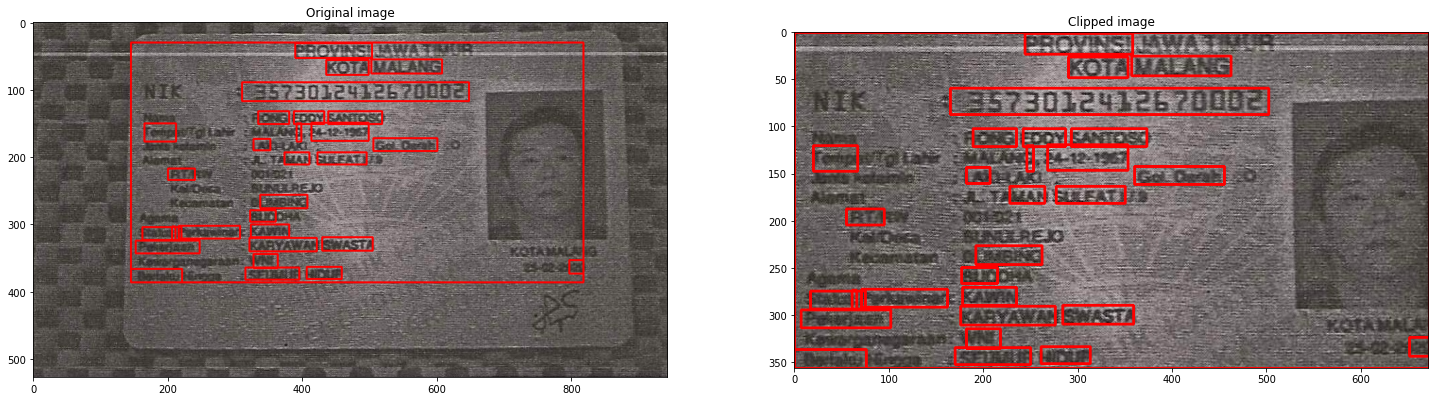

In [10]:
ind = random.randint(0, len(data_key_train)-1)
image = cv2.imread(data_key_train[ind]['file_path'])
image_copy = copy.deepcopy(image[
    data_key_train[ind]['data'][0]['boundingPoly']['vertices'][0]['y']
    :
    data_key_train[ind]['data'][0]['boundingPoly']['vertices'][2]['y'],
    data_key_train[ind]['data'][0]['boundingPoly']['vertices'][0]['x']
    :
    data_key_train[ind]['data'][0]['boundingPoly']['vertices'][2]['x'],
    :
])
for key in data_key_train[ind]['data']:
    image = cv2.rectangle(image, (key['boundingPoly']['vertices'][0]['x'], key['boundingPoly']['vertices'][0]['y']), (key['boundingPoly']['vertices'][2]['x'], key['boundingPoly']['vertices'][2]['y']), (255, 0, 0), 2)
    image_copy = cv2.rectangle(image_copy, (key['boundingPoly']['normalized_vertices'][0]['x'], key['boundingPoly']['normalized_vertices'][0]['y']), (key['boundingPoly']['normalized_vertices'][2]['x'], key['boundingPoly']['normalized_vertices'][2]['y']), (255, 0, 0), 2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,25))
ax1.imshow(image)
ax1.set_title("Original image")
ax2.imshow(image_copy)
ax2.set_title("Clipped image")

In [11]:
ind_to_heatmap_mapping_train = {str(i): np.zeros((256, 480)) for i, _ in enumerate(classes)}
ind_to_heatmap_mapping_val = {str(i): np.zeros((256, 480)) for i, _ in enumerate(classes)}
ind_to_heatmap_mapping_test = {str(i): np.zeros((256, 480)) for i, _ in enumerate(classes)}

In [12]:
def draw_labelmap(heatmap, coord, sigma=7):
    ul = [int(int(coord[0]) - 3 * sigma), int(int(coord[1]) - 3 * sigma)]
    br = [int(int(coord[0]) + 3 * sigma + 1), int(int(coord[1]) + 3 * sigma + 1)]   
    size = 6*sigma+1    
    g_x = max(0, -ul[0]), min(br[0], heatmap.shape[1]) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], heatmap.shape[0]) - ul[1]
    img_x = max(0, ul[0]), min(br[0], heatmap.shape[1])
    img_y = max(0, ul[1]), min(br[1], heatmap.shape[0])  
    x = np.arange(0, size, 1, float)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    g = np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] += g[g_y[0]:g_y[1], g_x[0]:g_x[1]]

def resize_point(image_width, image_height, point, size=RESIZE):
    new_w, new_h = size
    ratio_w = new_w / image_width
    ratio_h = new_h / image_height
    return (point[0] * ratio_w, point[1] * ratio_h)

def get_df(raw_data, heatmap_dict):
    data_list = []
    for ind, data in tqdm(enumerate(raw_data)):
        for i, item in enumerate(data['data']):
            if i == 0:
                continue
            center_coords = resize_point(data['normalized_image_width'], data['normalized_image_height'], (item['n_cx'], item['n_cy']))
            draw_labelmap(heatmap_dict[item['class_index']], center_coords)
            base_data = [
                    data['file_name'],
                    item['description'],
                ]
            derived_data = [
                    center_coords[0],
                    center_coords[1],
                    center_coords[0]/RESIZE[0], 
                    center_coords[1]/RESIZE[1],
                    data['normalized_image_width'],
                    data['normalized_image_height']
            ]
            text_embeddings = list(np.mean(bpemb.embed(item['description']), axis=0))
            labels = [
                order_mapping[item['class']],
                order_mapping[item['class']]/number_of_key_fields,
                int(item['is_key']),
                int(item['class_index'])
            ]
            data_list.append(
                base_data + derived_data + text_embeddings + labels
            )
    return pd.DataFrame(data_list, columns=
                        ['file_name', 'text']
                      + ['c_x_un', 'c_y_un', 'c_x', 'c_y', 'n_image_width', 'n_image_height']
                      + [str(i+1) for i in range(100)]
                      + ['order_un', 'order', 'is_key', 'key_label']
                    )

train_df = get_df(data_key_train, ind_to_heatmap_mapping_train)
val_df = get_df(data_key_val, ind_to_heatmap_mapping_val)
test_df = get_df(data_key_test, ind_to_heatmap_mapping_test)

80it [00:00, 227.23it/s]
13it [00:00, 179.28it/s]
23it [00:00, 185.86it/s]


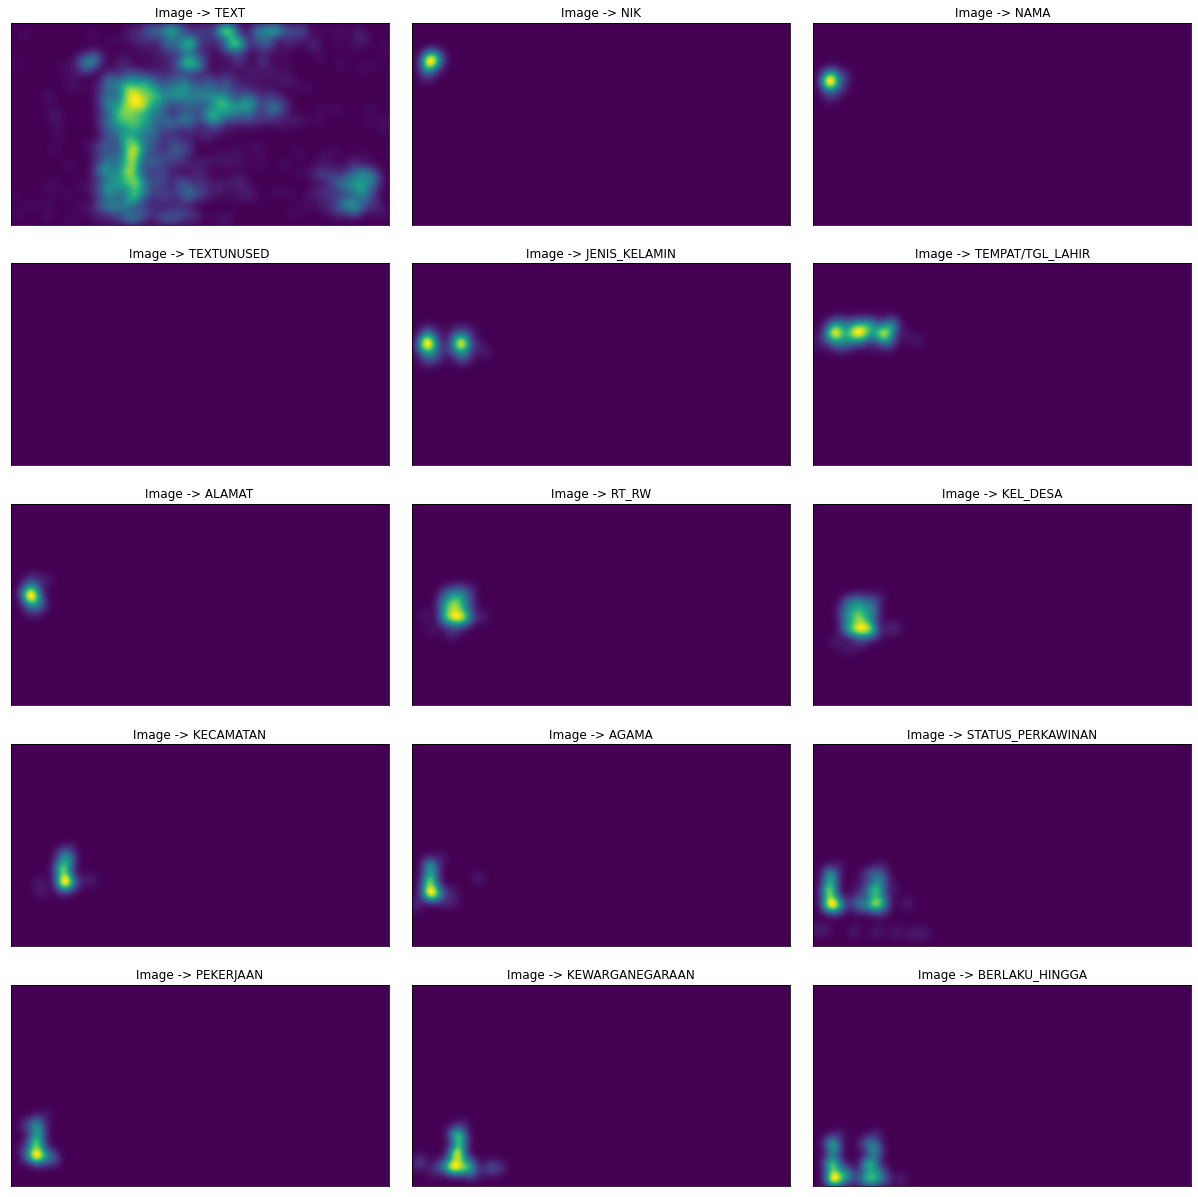

In [13]:
def plot_heatmap(heatmap_dict):
    rows, columns = 5, 3
    fig = plt.figure(figsize=(17, 17))
    for i in range(1, len(heatmap_dict)+1):
        fig.add_subplot(rows, columns, i)
        plt.title(f"Image -> {ind_to_classes_mapping[str(i-1)]}") 
        plt.xticks([])
        plt.yticks([])
        plt.imshow(heatmap_dict[str(i-1)])
    fig.tight_layout(pad=2.0)
    plt.show()

plot_heatmap(ind_to_heatmap_mapping_train)
# plot_heatmap(ind_to_heatmap_mapping_val)
# plot_heatmap(ind_to_heatmap_mapping_test)

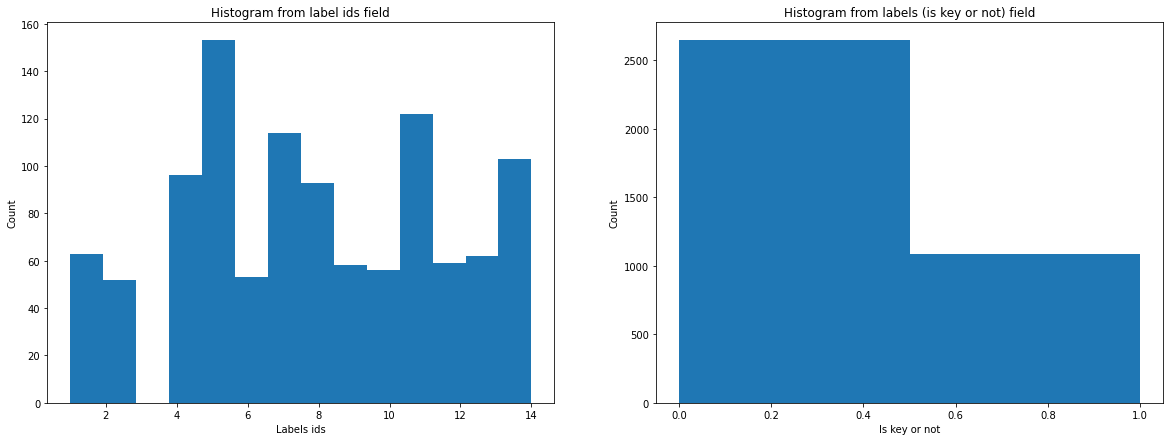

In [14]:
def plot_class_dist(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    ax1.hist(df[df['key_label'] !=0]['key_label'], bins=df['key_label'].nunique())
    ax1.set_title('Histogram from label ids field')
    ax1.set_xlabel('Labels ids')
    ax1.set_ylabel('Count')
    ax2.hist(df['is_key'], bins=df['is_key'].nunique())
    ax2.set_title('Histogram from labels (is key or not) field')
    ax2.set_xlabel('Is key or not')
    ax2.set_ylabel('Count')

plot_class_dist(train_df)
# plot_class_dist(val_df)
# plot_class_dist(test_df)

In [15]:
train_df['key_label'].nunique()

14

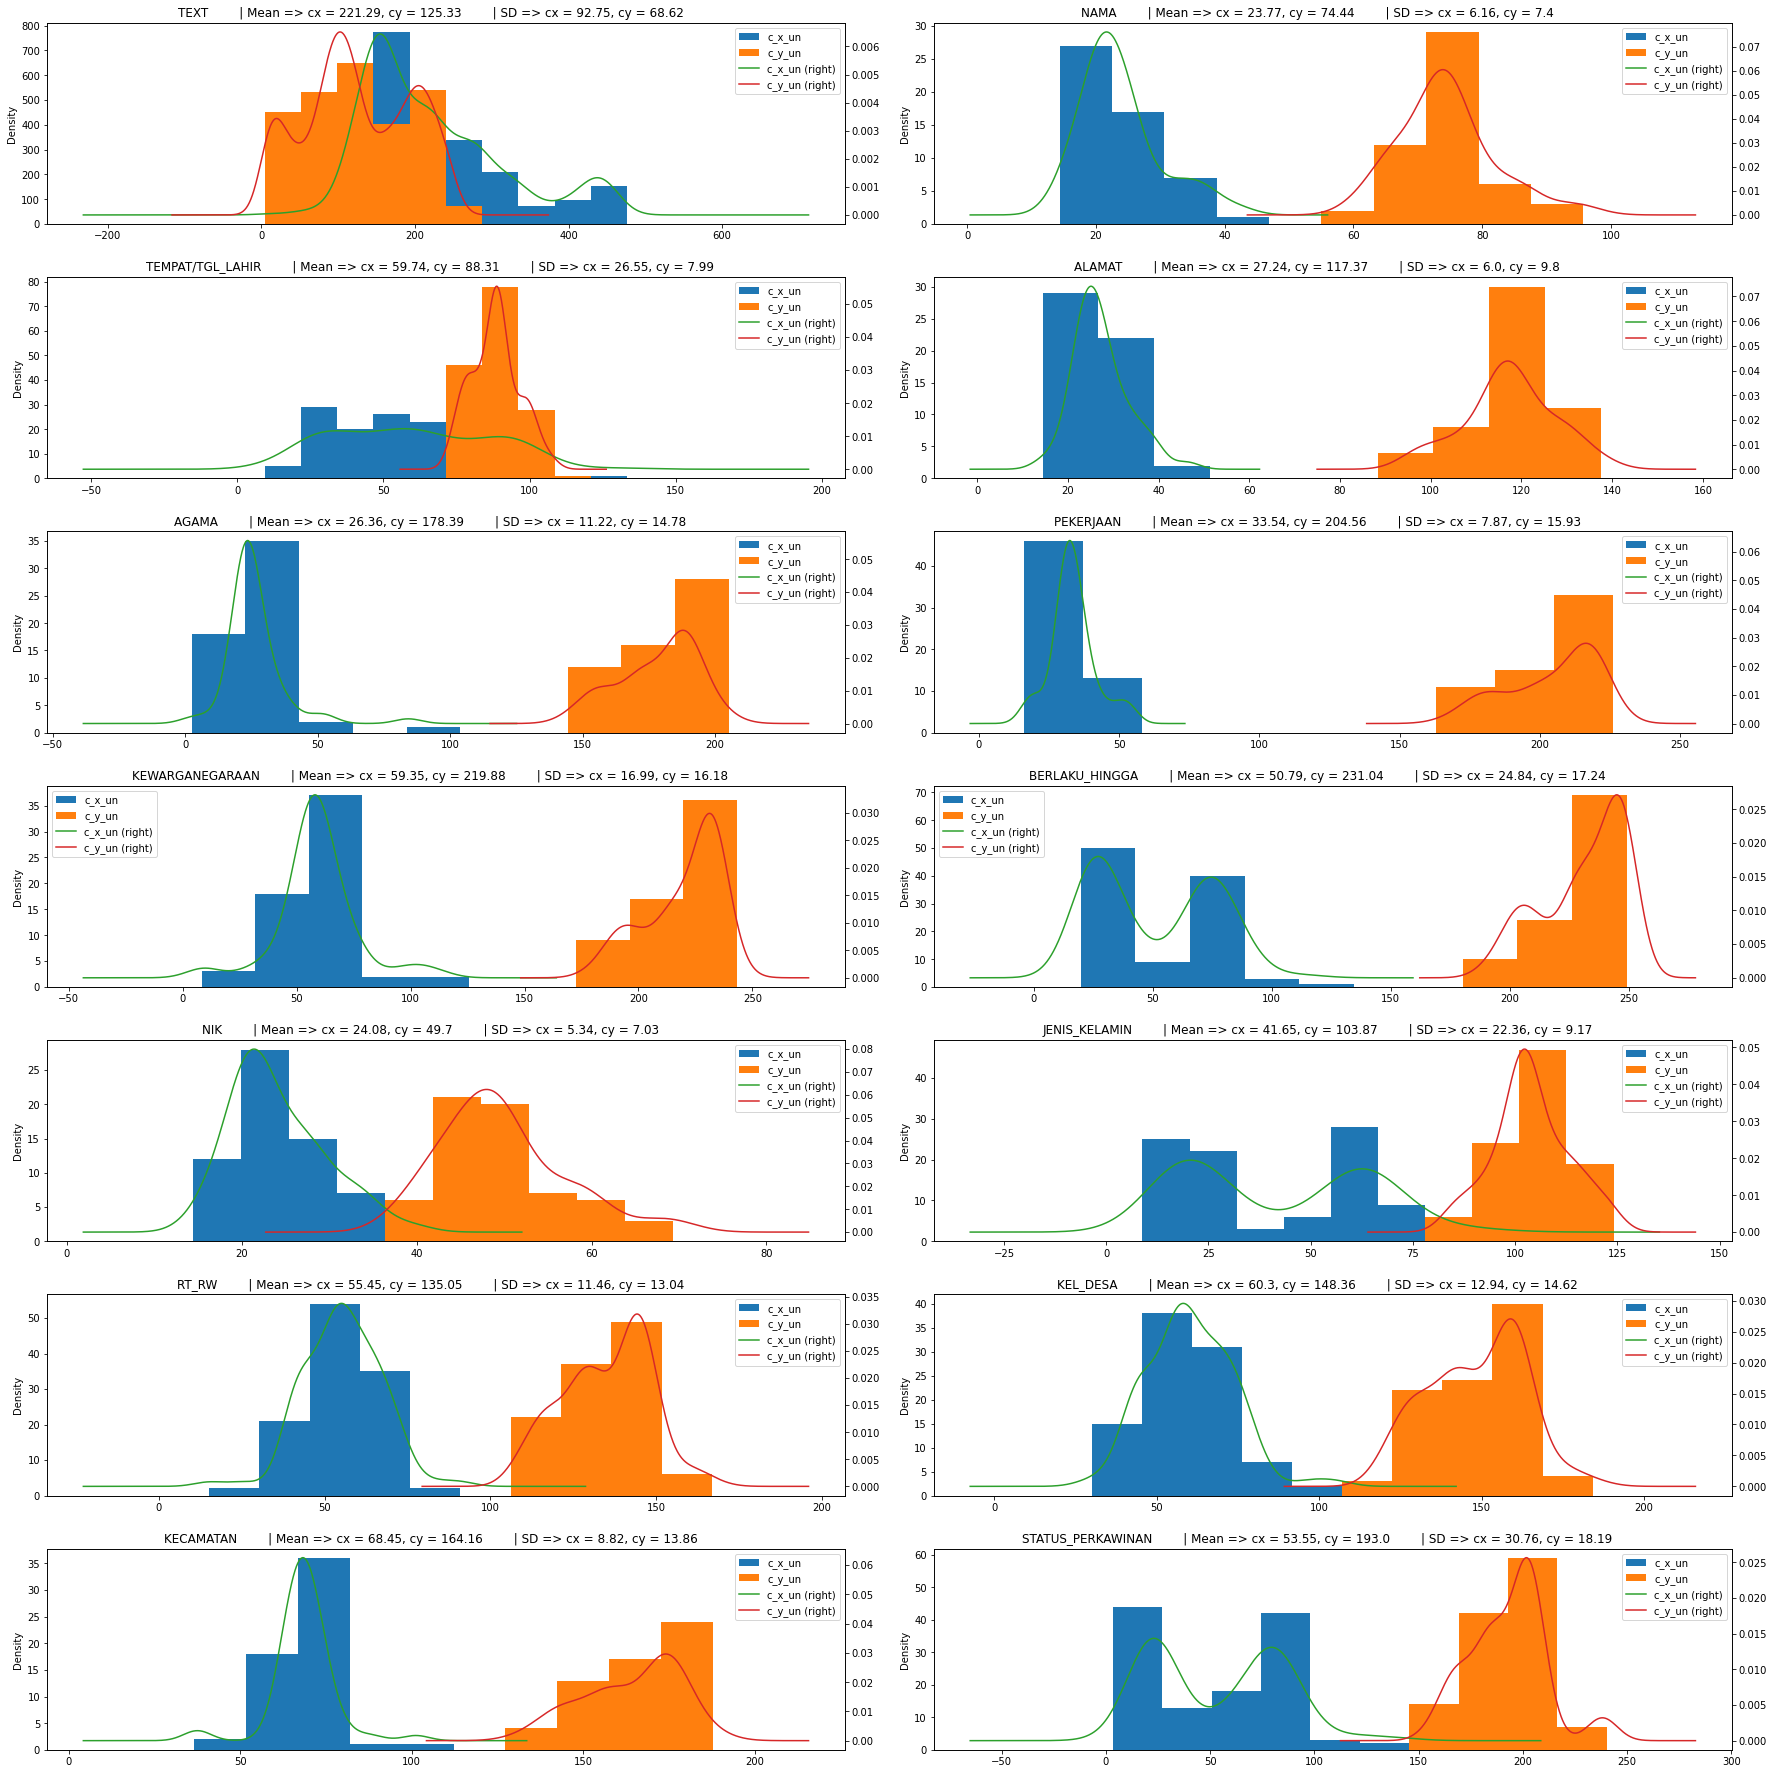

In [16]:
def plot_xy_dist(df):
    rows, columns = 7, 2
    fig = plt.figure(figsize=(25, 25))
    for ind, i in enumerate(df['key_label'].unique()):
        ax = fig.add_subplot(rows, columns, ind+1)
        df[df['key_label'] == i][['c_x_un', 'c_y_un']].plot(kind='hist', ax=ax)
        df[df['key_label'] == i][['c_x_un', 'c_y_un']].plot(kind='kde', ax=ax, secondary_y=True)
        plt.title(f"{ind_to_classes_mapping[str(i)]}\
        | Mean => cx = {round(df[df['key_label'] == i]['c_x_un'].mean(), 2)}, cy = {round(df[df['key_label'] == i]['c_y_un'].mean(), 2)}\
        | SD => cx = {round(df[df['key_label'] == i]['c_x_un'].std() , 2)}, cy = {round(df[df['key_label'] == i]['c_y_un'].std(), 2)}\
        ") 
    fig.tight_layout(pad=2.0)
    plt.show()

plot_xy_dist(train_df)
# plot_xy_dist(val_df)
# plot_xy_dist(test_df)

In [17]:
print(f'Lenght of train key df = {len(train_df)}\nLength of val key df = {len(val_df)}\nLength of test key df = {len(test_df)}')

Lenght of train key df = 3730
Length of val key df = 713
Length of test key df = 1320


In [18]:
train_df.head()

file_name        text      c_x_un     c_y_un       c_x       c_y  \
0  202106100907_0a         PRI  210.212766   9.309091  0.437943  0.036364   
1  202106100907_0a          VS  256.170213   9.309091  0.533688  0.036364   
2  202106100907_0a          al  315.744681   9.309091  0.657801  0.036364   
3  202106100907_0a  KABUPARTIS  268.936170  28.703030  0.560284  0.112121   
4  202106100907_0a        2000  149.787234  51.975758  0.312057  0.203030   

   n_image_width  n_image_height         1         2  ...        95        96  \
0            564             330  0.649381  0.074874  ... -0.233056 -0.319289   
1            564             330 -0.459255  0.424648  ...  0.159780 -0.017942   
2            564             330 -0.172893 -0.220884  ... -0.114714 -0.628498   
3            564             330 -0.193712 -0.266252  ... -0.030197 -0.018000   
4            564             330  0.315029 -0.043605  ... -0.123883 -0.146452   

         97        98        99       100  order_un  order  is_key  key_label  
0 -0.330267 -0.252453 -0.451853  0.712668         0    0.0       0          0  
1  1.190499  0.290374  0.973299  0.434918         0    0.0       0          0  
2 -0.877970 -0.509837  0.064313 -0.099291         0    0.0       0          0  
3  0.293573 -0.262149  0.000243 -0.009913         0    0.0       0          0  
4 -0.428663 -0.196154  0.105480  0.574372         0    0.0       0          0  

[5 rows x 112 columns]

## Detect Order of a Key Field

In [19]:
# Add jitter
class PixelJitter:
    
    def __init__(self, pixels=[0, 1, 2, 3], size=RESIZE):
        self.width, self.height = size
        self.pixels = pixels + [-1*p for p in pixels]

    def __call__(self, sample):
        embeddings, order = sample['embeddings'], sample['order']
        embeddings[0] += random.choice(self.pixels)/self.width
        embeddings[1] += random.choice(self.pixels)/self.height
        return {'embeddings': embeddings, 'order': order}
    
    
# Convert to tensor.
class ToTensor:

    def __call__(self, sample):
        embeddings, order = sample['embeddings'], sample['order']
        embeddings = torch.from_numpy(embeddings)
        order = torch.from_numpy(np.asarray(order))
        return {'embeddings': embeddings.float(), 'order': order}
        
        
class CustomDatasetKeyFieldOrder(Dataset):
    
    def __init__(self, data, transforms=None, overfit=False, overfit_batch_size=32):
        self.data = data.drop(['file_name', 'text', 'n_image_width', 'n_image_height', 'c_x_un', 'c_y_un', 'order_un', 'order', 'is_key', 'key_label'], axis=1)
        self.labels = data[['order_un']]
        self.overfit = overfit
        self.overfit_batch_size = overfit_batch_size
        self.transforms = transforms

    def __len__(self):
        return len(self.data) if not self.overfit else self.overfit_batch_size

    def __getitem__(self, index):
        sample = {
            
            'embeddings': np.array(self.data.iloc[index]),
            'order': self.labels.iloc[index]['order_un']
        }
        sample_output = self.transforms(sample)
        return sample_output['embeddings'], sample_output['order']


class DataKeyFieldOrder:

    def __init__(self, train_df, val_df, test_df, transforms=None, batch_size=32, overfit=False, overfit_batch_size=32):
        self.train, self.val, self.test = train_df, val_df, test_df
        self.shuffle = True
        self.batch_size = batch_size
        self.overfit = overfit
        self.overfit_batch_size = overfit_batch_size
        self.transforms = self.get_transforms() if transforms is None or not isinstance(transforms, dict) else transforms

    def get_transforms(self):
        TRANSFORMS = {
            'train': transforms.Compose([
                PixelJitter(),
                ToTensor()
            ]),
            'val': transforms.Compose([
                PixelJitter(),
                ToTensoror()
            ]),
            'test': transforms.Compose([
                PixelJitter(),
                ToTensor()
            ])
        }
        return TRANSFORMS

    def get_loaders(self):
        train_dataset = CustomDatasetKeyFieldOrder(data=self.train, transforms=self.transforms['train'], overfit=self.overfit, overfit_batch_size=self.overfit_batch_size)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=self.shuffle, pin_memory=True)
        val_dataset = CustomDatasetKeyFieldOrder(data=self.val, transforms=self.transforms['val'], overfit=self.overfit, overfit_batch_size=self.overfit_batch_size)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=self.batch_size, shuffle=self.shuffle, pin_memory=True)
        test_dataset = CustomDatasetKeyFieldOrder(data=self.test, transforms=self.transforms['test'], overfit=self.overfit, overfit_batch_size=self.overfit_batch_size)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=self.batch_size, shuffle=self.shuffle, pin_memory=True)
        return train_dataset, train_loader, val_dataset, val_loader, test_dataset, test_loader

    def visualize_outputs(self):
        _, trainloader, _, _, _, _ = self.get_loaders()
        dataiter = iter(trainloader)
        embeddings, order = dataiter.next()
        print('Model input => ', embeddings.size())
        print('Embeddings =>\n', embeddings)
        print('Model output => ', order.size())
        print('Order =>\n', order)

In [20]:
data_key_order = DataKeyFieldOrder(train_df, val_df, test_df)
data_key_order.visualize_outputs()
_, train_key_order_loader, _, val_key_order_loader, _, test_key_order_loader = data_key_order.get_loaders()

Model input =>  torch.Size([32, 102])
Embeddings =>
 tensor([[ 0.5592,  0.3984, -0.1290,  ...,  0.1716, -0.2291,  0.1437],
        [ 0.9181,  0.8219, -0.1118,  ..., -0.6074,  0.0276,  0.0815],
        [ 0.4605,  0.1301, -0.0399,  ..., -0.6294, -0.1317,  0.3972],
        ...,
        [ 0.1447,  0.9700,  0.7776,  ...,  0.0270, -0.3868,  0.3813],
        [ 0.1078,  0.5152, -0.2277,  ..., -0.3840, -0.1237,  0.3663],
        [ 0.5998,  0.3578, -0.7566,  ..., -0.4604, -0.5181, -0.8626]])
Model output =>  torch.Size([32])
Order =>
 tensor([ 0,  0,  0, 11,  6,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  2,
         0,  0,  3,  1,  0,  0,  0, 10,  0,  0,  0, 13,  6,  0])


In [21]:
ce_weights = np.asarray([1 - (i / len(train_df)) for i in list(train_df['key_label'].value_counts().sort_index())])
ce_weights

array([0.29061662, 0.98310992, 0.98605898, 0.97426273, 0.95898123,
       0.98579088, 0.969437  , 0.97506702, 0.9844504 , 0.9849866 ,
       0.96729223, 0.98418231, 0.98337802, 0.97238606])

In [22]:
class KeyOrderModel(nn.Module):

    def __init__(self, crossentropy_head=len(set(order_mapping.values()))):
        super().__init__()
        self.fc1 = nn.Linear(102, 256)
        self.fc2 = nn.Linear(256, crossentropy_head)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return F.log_softmax(self.fc2(x), dim = 1)
    
    
model_key_order = KeyOrderModel()
output = model_key_order(torch.randn(32, 102))
print(type(output))
print(f"KeyOrderModel Output -> {output.size()}")

<class 'torch.Tensor'>
KeyOrderModel Output -> torch.Size([32, 14])


In [23]:
class LitKeyOrderModel(pl.LightningModule):

    def __init__(self, train_loader, val_loader, batch_size=128, learning_rate=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(ce_weights).float())
        self.model = KeyOrderModel()
        self.learning_rate=learning_rate
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.batch_size = batch_size
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay

    def forward(self, x):
        return self.model(x)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def on_train_end(self, *args, **kwargs):
        self.logger.experiment.add_graph(LitKeyOrderModel(self.train_loader, self.val_loader),torch.randn((1, 102)))
        for name, params in self.named_parameters():
            self.logger.experiment.add_histogram(name, params, self.current_epoch)

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self.forward(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        y_hat = self.forward(x)   
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss, prog_bar=True, on_epoch=True)
        return loss
    
    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def configure_optimizers(self):
        steps_per_epoch = len(self.train_loader) // self.batch_size
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=self.learning_rate, 
            betas=self.betas, 
            eps=self.eps, 
            weight_decay=self.weight_decay
        )
        reduce_on_plateau_lr_scheduler = {
            "scheduler": ReduceLROnPlateau(
                optimizer=optimizer,
                min_lr=1e-7
            ),
            "monitor": "val_loss",
            "interval": "epoch"
        }
        cyclic_lr_scheduler = {
            "scheduler": CyclicLR(
                optimizer=optimizer,
                base_lr=self.learning_rate,
                max_lr=1e-6,
                cycle_momentum=False # False with AdamW
            ),
            "interval": "step"
        }
        return [optimizer], [cyclic_lr_scheduler]
    
    def get_progress_bar_dict(self):
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        items.pop("loss", None)
        return items

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | KeyOrderModel    | 30.0 K
-----------------------------------------------
30.0 K    Trainable params
0         Non-trainable params
30.0 K    Total params
0.120     Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 99 steps due to diverging loss.
Restoring states from the checkpoint file at ../logs/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at ../logs/lr_find_temp_model.ckpt


CPU times: user 5.06 s, sys: 18.5 ms, total: 5.08 s
Wall time: 1.35 s


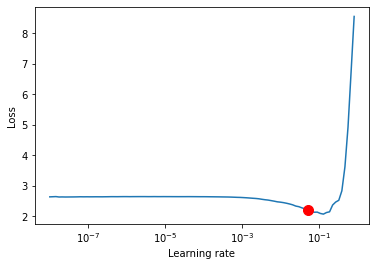

In [24]:
%%time
model_key_order = LitKeyOrderModel(train_loader=train_key_order_loader, val_loader=val_key_order_loader, batch_size=32)
trainer_key_order = pl.Trainer(auto_lr_find=True, gpus=1 if torch.cuda.is_available() else None, progress_bar_refresh_rate=0, default_root_dir='../logs')
lr_finder_key_order = trainer_key_order.tuner.lr_find(model_key_order)
fig = lr_finder_key_order.plot(suggest=True)
fig.show()

In [24]:
%%time
trainer_key_order = pl.Trainer(default_root_dir='../logs',
                               precision=32,
                               limit_train_batches=0.5,
                               gpus=1 if torch.cuda.is_available() else None, 
                               max_epochs=2,
                               logger=TensorBoardLogger('../logs', name='2022-01-06_combined_orc_kyc-key-fields-order'),
                               callbacks=[
                                      LearningRateMonitor(logging_interval="step"), 
                                      ModelCheckpoint(monitor="train_loss"),
                                  ],
#                              resume_from_checkpoint='../logs' + '/' +'key_model' +'/version_0/checkpoints/epoch=98-step=6137.ckpt'
                               )

trainer_key_order.fit(LitKeyOrderModel(train_loader=train_key_order_loader, val_loader=val_key_order_loader))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-02-03 22:30:26.218680: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-03 22:30:26.218705: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | KeyOrderModel    | 30.0 K
-----------------------------------------------
30.0 K    Trainable params
0         Non-trainable params
30.0 K    Total params
0.120     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 3.69 s, sys: 217 ms, total: 3.91 s
Wall time: 3.53 s


In [26]:
model_key_order = LitKeyOrderModel.load_from_checkpoint(checkpoint_path='../logs'+ '/' + '2022-01-06_combined_orc_kyc-key-fields-order' +'/version_0/checkpoints/epoch=148-step=8641.ckpt', train_loader=train_key_order_loader, val_loader=val_key_order_loader)
model_key_order.eval()

LitKeyOrderModel(
  (criterion): CrossEntropyLoss()
  (model): KeyOrderModel(
    (fc1): Linear(in_features=102, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=14, bias=True)
    (relu): ReLU()
  )
)

In [27]:
trainer_key_order.test(model_key_order, dataloaders=test_key_order_loader)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.32576343417167664}
--------------------------------------------------------------------------------


[{'test_loss': 0.32576343417167664}]

In [28]:
df_dict_key_order_res = {
    'pred_order': [],
    'true_order': [],
}
for embeddings, orders in test_key_order_loader:
    y_hat = model_key_order(embeddings)
    y_hat = y_hat.cpu().detach().numpy()
    y_hat = np.argmax(y_hat, axis=1)
    orders = orders.cpu().detach().numpy()
    for i in range(len(orders)):
        df_dict_key_order_res['pred_order'].append(y_hat[i])
        df_dict_key_order_res['true_order'].append(orders[i])
df_dict_key_order_res = pd.DataFrame.from_dict(df_dict_key_order_res)
df_dict_key_order_res

pred_order  true_order
0             12           0
1              3           3
2              0           0
3              0           0
4              0           0
...          ...         ...
1315           0           0
1316           0           0
1317           0           0
1318           0           0
1319           0           0

[1320 rows x 2 columns]

In [29]:
pd.set_option('display.max_rows', 10) # make 10 -> None to view all
df_dict_key_order_res[df_dict_key_order_res['true_order'] != 0]

pred_order  true_order
1              3           3
6             10          10
7              4           4
10            13          13
11             2           2
...          ...         ...
1300           8           8
1303           8           8
1305           7           7
1311          10          10
1312           0           3

[370 rows x 2 columns]

In [30]:
print(classification_report(df_dict_key_order_res['pred_order'], df_dict_key_order_res['true_order']))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       942
           1       0.90      1.00      0.95        19
           2       0.94      0.89      0.92        19
           3       0.93      0.95      0.94        56
           4       1.00      0.94      0.97        34
           5       0.89      1.00      0.94        17
           6       0.98      0.81      0.88        52
           7       0.68      0.82      0.74        28
           8       1.00      0.90      0.95        20
           9       0.95      0.95      0.95        20
          10       0.91      0.91      0.91        35
          11       0.89      0.84      0.86        19
          12       0.95      0.69      0.80        26
          13       0.89      0.97      0.93        33

    accuracy                           0.96      1320
   macro avg       0.92      0.90      0.91      1320
weighted avg       0.96      0.96      0.96      1320



## Detect Key Field and classify it

In [31]:
# Add jitter
class PixelJitter:
    
    def __init__(self, pixels=[0, 1, 2, 3], size=RESIZE):
        self.width, self.height = size
        self.pixels = pixels + [-1*p for p in pixels]

    def __call__(self, sample):
        embeddings, labels = sample['embeddings'], sample['labels']
        embeddings[0] += random.choice(self.pixels)/self.width
        embeddings[1] += random.choice(self.pixels)/self.height
        return {'embeddings': embeddings, 'labels': labels}
    
    
# Convert to tensor.
class ToTensor:

    def __call__(self, sample):
        embeddings, labels = sample['embeddings'], sample['labels']
        embeddings = torch.from_numpy(embeddings)
        labels = torch.from_numpy(np.asarray(labels))
        return {'embeddings': embeddings.float(), 'labels': labels}
    
        
class CustomDatasetKeyField(Dataset):
    
    def __init__(self, data, transforms=None, overfit=False, overfit_batch_size=32):
        self.data = data.drop(['file_name', 'text', 'n_image_width', 'n_image_height', 'c_x_un', 'c_y_un', 'order_un', 'order', 'is_key', 'key_label'], axis=1)
        self.labels = data[['key_label']]
        self.overfit = overfit
        self.overfit_batch_size = overfit_batch_size
        self.transforms = transforms

    def __len__(self):
        return len(self.data) if not self.overfit else self.overfit_batch_size

    def __getitem__(self, index):
        sample = {
            'embeddings': np.array(self.data.iloc[index]),
            'labels': self.labels.iloc[index]['key_label']
        }
        sample_output = self.transforms(sample)
        return sample_output['embeddings'], sample_output['labels']


class DataKeyField:

    def __init__(self, train_df, val_df, test_df, transforms=None, batch_size=32, overfit=False, overfit_batch_size=32):
        self.train, self.val, self.test = train_df, val_df, test_df
        self.shuffle = True
        self.batch_size = batch_size
        self.overfit = overfit
        self.overfit_batch_size = overfit_batch_size
        self.transforms = self.get_transforms() if transforms is None or not isinstance(transforms, dict) else transforms

    def get_transforms(self):
        TRANSFORMS = {
            'train': transforms.Compose([
                PixelJitter(),
                ToTensor()
            ]),
            'val': transforms.Compose([
                PixelJitter(),
                ToTensor()
            ]),
            'test': transforms.Compose([
                PixelJitter(),
                ToTensor()
            ])
        }
        return TRANSFORMS

    def get_loaders(self):
        train_dataset = CustomDatasetKeyField(data=self.train, transforms=self.transforms['train'], overfit=self.overfit, overfit_batch_size=self.overfit_batch_size)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=self.shuffle, pin_memory=True)
        val_dataset = CustomDatasetKeyField(data=self.val, transforms=self.transforms['val'], overfit=self.overfit, overfit_batch_size=self.overfit_batch_size)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=self.batch_size, shuffle=self.shuffle, pin_memory=True)
        test_dataset = CustomDatasetKeyField(data=self.test, transforms=self.transforms['test'], overfit=self.overfit, overfit_batch_size=self.overfit_batch_size)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=self.batch_size, shuffle=self.shuffle, pin_memory=True)
        return train_dataset, train_loader, val_dataset, val_loader, test_dataset, test_loader

    def visualize_outputs(self):
        _, trainloader, _, _, _, _ = self.get_loaders()
        dataiter = iter(trainloader)
        embeddings, labels = dataiter.next()
        print('Model input => ', embeddings.size())
        print('Embeddings =>\n', embeddings)
        print('Model output => ', labels.size())
        print('Labels =>\n', labels)

In [32]:
data_key = DataKeyField(train_df, val_df, test_df)
data_key.visualize_outputs()
_, train_key_loader, _, val_key_loader, _, test_key_loader = data_key.get_loaders()

Model input =>  torch.Size([32, 102])
Embeddings =>
 tensor([[ 0.8330,  0.8254, -0.0399,  ..., -0.6294, -0.1317,  0.3972],
        [ 0.0605,  0.4181, -0.1747,  ..., -0.3822, -0.1056,  0.0366],
        [ 0.0975,  0.5037, -0.2040,  ..., -0.2784, -0.2654, -0.5507],
        ...,
        [ 0.5916,  0.8652, -0.0047,  ..., -0.2296, -0.1942,  0.2597],
        [ 0.3720,  0.8599, -0.2903,  ..., -0.1048, -0.2238,  0.2390],
        [ 0.3610,  0.3627,  0.4002,  ..., -0.3784, -0.2533,  0.4200]])
Model output =>  torch.Size([32])
Labels =>
 tensor([ 0,  4,  8,  0,  0,  0,  0,  9,  0,  6,  0,  0,  0,  0,  0,  0,  0,  0,
        11, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])


In [33]:
ce_weights = np.asarray([1 - (i / len(train_df)) for i in list(pd.concat([train_df['key_label'].value_counts(), pd.Series([0], index=[3])]).sort_index())])
ce_weights

array([0.29061662, 0.98310992, 0.98605898, 1.        , 0.97426273,
       0.95898123, 0.98579088, 0.969437  , 0.97506702, 0.9844504 ,
       0.9849866 , 0.96729223, 0.98418231, 0.98337802, 0.97238606])

In [34]:
class KeyModel(nn.Module):

    def __init__(self, bce_head=1, crossentropy_head=len(ind_to_classes_mapping)):
        super().__init__()
        self.fc1 = nn.Linear(102, 256)
        self.fc = nn.Linear(256, crossentropy_head)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return F.log_softmax(self.fc(x), dim = 1)
    
    
model_key = KeyModel()
output = model_key(torch.randn(32, 102))
print(type(output))
print(output.shape)

<class 'torch.Tensor'>
torch.Size([32, 15])


In [35]:
class LitKeyModel(pl.LightningModule):

    def __init__(self, train_loader, val_loader, batch_size=128, learning_rate=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss(weight=torch.from_numpy(ce_weights).float())
        self.model = KeyModel()
        self.learning_rate=learning_rate
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.batch_size = batch_size
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay

    def forward(self, x):
        return self.model(x)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self.forward(x)   
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def on_train_end(self, *args, **kwargs):
        self.logger.experiment.add_graph(LitKeyModel(self.train_loader, self.val_loader),torch.randn((1, 102)))
        for name, params in self.named_parameters():
            self.logger.experiment.add_histogram(name, params, self.current_epoch)

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self.forward(x)   
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        y_hat = self.forward(x)   
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss, prog_bar=True, on_epoch=True)
        return loss
    
    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def configure_optimizers(self):
        steps_per_epoch = len(self.train_loader) // self.batch_size
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=self.learning_rate, 
            betas=self.betas, 
            eps=self.eps, 
            weight_decay=self.weight_decay
        )
        reduce_on_plateau_lr_scheduler = {
            "scheduler": ReduceLROnPlateau(
                optimizer=optimizer,
                min_lr=1e-7
            ),
            "monitor": "val_loss",
            "interval": "epoch"
        }
        cyclic_lr_scheduler = {
            "scheduler": CyclicLR(
                optimizer=optimizer,
                base_lr=self.learning_rate,
                max_lr=1e-6,
                cycle_momentum=False # False with AdamW
            ),
            "interval": "step"
        }
        return [optimizer], [cyclic_lr_scheduler]
    
    def get_progress_bar_dict(self):
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        items.pop("loss", None)
        return items

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | KeyModel         | 30.2 K
-----------------------------------------------
30.2 K    Trainable params
0         Non-trainable params
30.2 K    Total params
0.121     Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restoring states from the checkpoint file at ../logs/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at ../logs/lr_find_temp_model.ckpt


CPU times: user 5.01 s, sys: 15.8 ms, total: 5.02 s
Wall time: 1.69 s


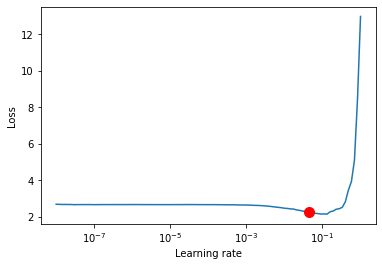

In [36]:
%%time
model_key = LitKeyModel(train_loader=train_key_loader, val_loader=val_key_loader, batch_size=32)
trainer_key = pl.Trainer(auto_lr_find=True, gpus=1 if torch.cuda.is_available() else None, progress_bar_refresh_rate=0, default_root_dir='../logs')
lr_finder_key = trainer_key.tuner.lr_find(model_key)
fig = lr_finder_key.plot(suggest=True)
fig.show()

In [37]:
%%time
trainer_key = pl.Trainer(default_root_dir='../logs',
                     precision=32,
                     limit_train_batches=0.5,
                     gpus=1 if torch.cuda.is_available() else None, 
                     max_epochs=150,
                     logger=TensorBoardLogger('../logs', name='2022-01-06_combined_orc_kyc-key-fields'),
                     callbacks=[
                            LearningRateMonitor(logging_interval="step"), 
                            ModelCheckpoint(monitor="train_loss"),
                        ],
#                      resume_from_checkpoint='../logs' + '/' +'key_model' +'/version_0/checkpoints/epoch=98-step=6137.ckpt'
                     )

trainer_key.fit(LitKeyModel(train_loader=train_key_loader, val_loader=val_key_loader))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | KeyModel         | 30.2 K
-----------------------------------------------
30.2 K    Trainable params
0         Non-trainable params
30.2 K    Total params
0.121     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 10min 53s, sys: 4.76 s, total: 10min 57s
Wall time: 2min 56s


In [38]:
model_key = LitKeyModel.load_from_checkpoint(checkpoint_path='../logs'+ '/' + '2022-01-06_combined_orc_kyc-key-fields' +'/version_0/checkpoints/epoch=149-step=8699.ckpt', train_loader=train_key_loader, val_loader=val_key_loader)
model_key.eval()

LitKeyModel(
  (criterion): CrossEntropyLoss()
  (model): KeyModel(
    (fc1): Linear(in_features=102, out_features=256, bias=True)
    (fc): Linear(in_features=256, out_features=15, bias=True)
    (relu): ReLU()
  )
)

In [39]:
trainer_key.test(model_key, dataloaders=test_key_loader)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.34731751680374146}
--------------------------------------------------------------------------------


[{'test_loss': 0.34731751680374146}]

In [40]:
df_dict_key_res = {
    'pred_label': [],
    'true_label': []
}
for embeddings, labels in test_key_loader:
    y_hat = model_key(embeddings)
    y_hat = y_hat.cpu().detach().numpy()
    y_hat = np.argmax(y_hat, axis=1)
    labels = labels.cpu().detach().numpy()
    for i in range(len(labels)):
        df_dict_key_res['pred_label'].append(y_hat[i])
        df_dict_key_res['true_label'].append(labels[i])
df_key_res = pd.DataFrame.from_dict(df_dict_key_res)
df_key_res

pred_label  true_label
0              0           0
1              0           0
2              0           0
3              0           0
4              0           0
...          ...         ...
1315           0           0
1316           0           0
1317           1           1
1318          12          12
1319           0           0

[1320 rows x 2 columns]

In [41]:
pd.set_option('display.max_rows', 10) # make 10 -> None to view all
df_key_res[df_key_res['true_label'] != 0]

pred_label  true_label
6             10          10
12             8           8
15            14          14
16            12          12
21            14          14
...          ...         ...
1309           5           5
1313          14          14
1314          11          11
1317           1           1
1318          12          12

[370 rows x 2 columns]

In [42]:
print(classification_report(df_key_res['pred_label'], df_key_res['true_label']))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       938
           1       0.90      1.00      0.95        19
           2       0.94      0.81      0.87        21
           4       1.00      0.84      0.91        38
           5       0.93      0.91      0.92        58
           6       0.89      1.00      0.94        17
           7       0.95      0.80      0.87        51
           8       0.68      0.88      0.77        26
           9       1.00      0.90      0.95        20
          10       0.95      0.95      0.95        20
          11       0.91      0.91      0.91        35
          12       0.89      0.80      0.84        20
          13       1.00      0.76      0.86        25
          14       0.83      0.94      0.88        32

    accuracy                           0.96      1320
   macro avg       0.92      0.89      0.90      1320
weighted avg       0.96      0.96      0.96      1320



In [43]:
train_df.head()

file_name        text      c_x_un     c_y_un       c_x       c_y  \
0  202106100907_0a         PRI  210.212766   9.309091  0.437943  0.036364   
1  202106100907_0a          VS  256.170213   9.309091  0.533688  0.036364   
2  202106100907_0a          al  315.744681   9.309091  0.657801  0.036364   
3  202106100907_0a  KABUPARTIS  268.936170  28.703030  0.560284  0.112121   
4  202106100907_0a        2000  149.787234  51.975758  0.312057  0.203030   

   n_image_width  n_image_height         1         2  ...        95        96  \
0            564             330  0.649381  0.074874  ... -0.233056 -0.319289   
1            564             330 -0.459255  0.424648  ...  0.159780 -0.017942   
2            564             330 -0.172893 -0.220884  ... -0.114714 -0.628498   
3            564             330 -0.193712 -0.266252  ... -0.030197 -0.018000   
4            564             330  0.315029 -0.043605  ... -0.123883 -0.146452   

         97        98        99       100  order_un  order  is_key  key_label  
0 -0.330267 -0.252453 -0.451853  0.712668         0    0.0       0          0  
1  1.190499  0.290374  0.973299  0.434918         0    0.0       0          0  
2 -0.877970 -0.509837  0.064313 -0.099291         0    0.0       0          0  
3  0.293573 -0.262149  0.000243 -0.009913         0    0.0       0          0  
4 -0.428663 -0.196154  0.105480  0.574372         0    0.0       0          0  

[5 rows x 112 columns]

In [44]:
X_train = torch.tensor(train_df.drop(['file_name', 'text', 'n_image_width', 'n_image_height', 'c_x_un', 'c_y_un', 'order_un', 'order', 'is_key', 'key_label'], axis=1).to_numpy()).float()
X_train_target = torch.tensor(train_df[['key_label']].to_numpy()).float()
X_val= torch.tensor(val_df.drop(['file_name', 'text', 'n_image_width', 'n_image_height', 'c_x_un', 'c_y_un', 'order_un', 'order', 'is_key', 'key_label'], axis=1).to_numpy()).float()
X_val_target = torch.tensor(val_df[['key_label']].to_numpy()).float()
X_test = torch.tensor(test_df.drop(['file_name', 'text', 'n_image_width', 'n_image_height', 'c_x_un', 'c_y_un', 'order_un','order', 'is_key', 'key_label'], axis=1).to_numpy()).float()
X_test_target = torch.tensor(test_df[['key_label']].to_numpy()).float()

In [45]:
def modified_f(in_vec):
    return model_key.forward(in_vec)

In [46]:
def visualize_attribution(data, attr_test, legend='', heading=''):
    x_axis_data = np.arange(data.shape[1])
    x_axis_data_labels = ['C-X', 'C-Y'] + [f'Embedding-{str(i+1)}' for i in np.arange(attr_test.shape[1]-2)]
    attr_test_sum = attr_test.detach().numpy().sum(0)
    attr_test_norm_sum = attr_test_sum / np.linalg.norm(attr_test_sum, ord=1)
    lin_weight = model_key.model.fc1.weight[0].detach().numpy()
    y_axis_lin_weight = lin_weight / np.linalg.norm(lin_weight, ord=1)
    width = 0.5
    FONT_SIZE = 18
    legends = [legend, 'Weights']
    plt.figure(figsize=(25, 10))
    ax = plt.subplot()
    ax.set_title(heading)
    ax.set_ylabel('Attributions')
    plt.rc('font', size=FONT_SIZE)
    plt.rc('axes', titlesize=FONT_SIZE)
    plt.rc('axes', labelsize=FONT_SIZE)
    plt.rc('legend', fontsize=FONT_SIZE - 4)
    ax.bar(x_axis_data, attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
    ax.bar(x_axis_data + 1 * width, y_axis_lin_weight, width, align='center', alpha=1.0, color='grey')
    ax.autoscale_view()
    plt.tight_layout()
    plt.xticks(rotation=90)
    ax.set_xticks(x_axis_data + 0.5)
    ax.set_xticklabels(x_axis_data_labels)
    plt.legend(legends, loc=0)
    plt.show()

ig_attr_test ->  torch.Size([1320, 102])


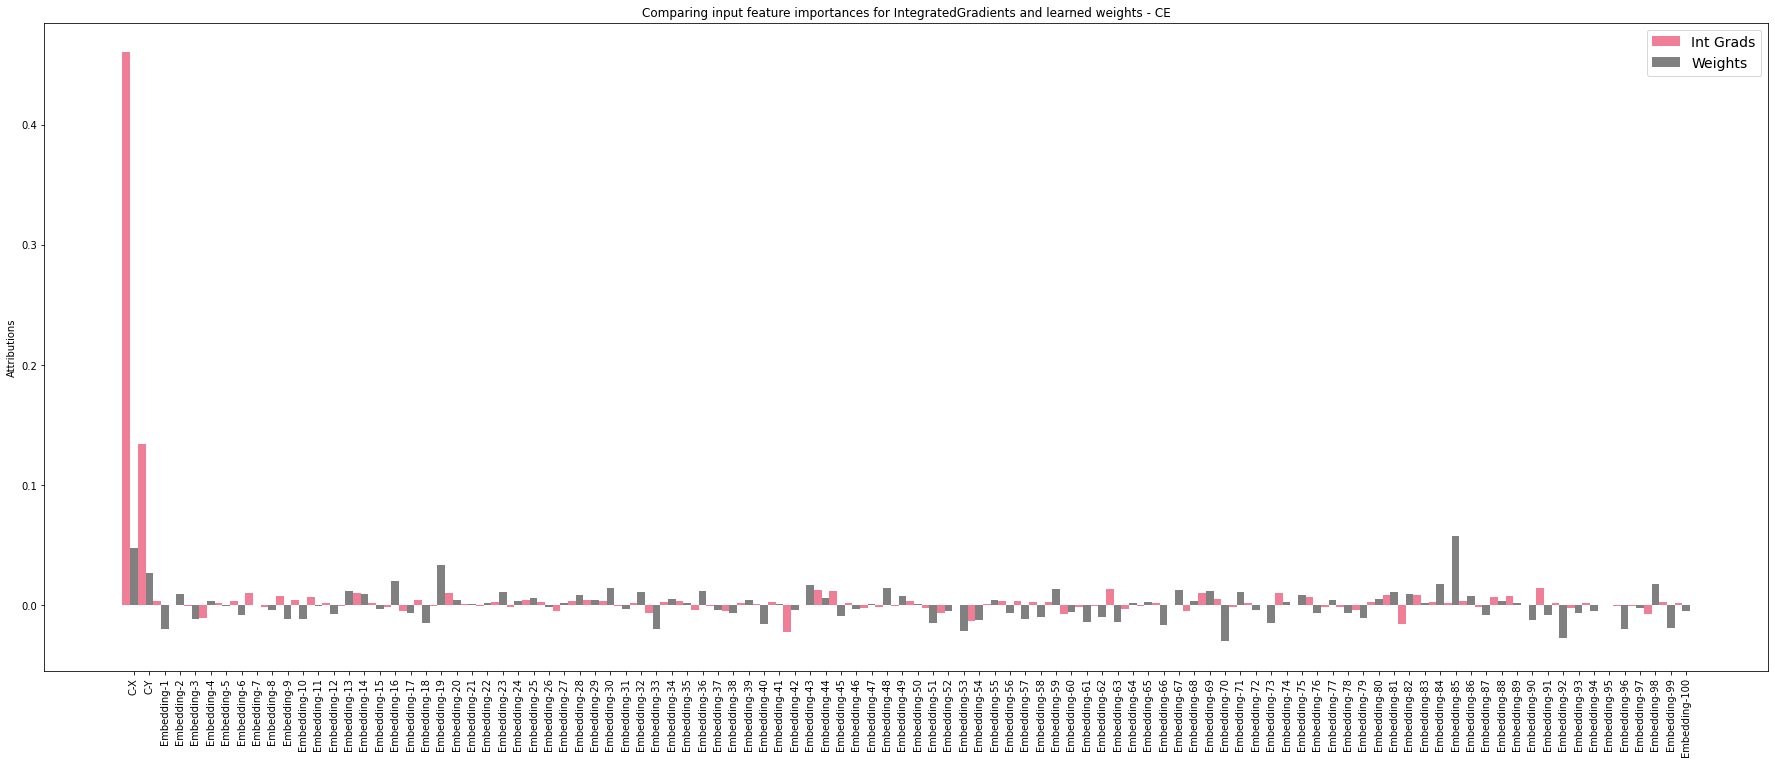

CPU times: user 11.5 s, sys: 313 ms, total: 11.8 s
Wall time: 11 s


In [47]:
%%time
# Attribution check for CrossEntropy head

ig = IntegratedGradients(modified_f)
# Target is not needed if the number of output neuron is 1.
ig_attr_test = ig.attribute(inputs=X_test, target=X_test_target.squeeze(1).type(torch.IntTensor).tolist())
print('ig_attr_test -> ', ig_attr_test.size())
visualize_attribution(X_test, ig_attr_test, 'Int Grads', 'Comparing input feature importances for IntegratedGradients and learned weights - CE')

ig_nt_attr_test ->  torch.Size([1320, 102])


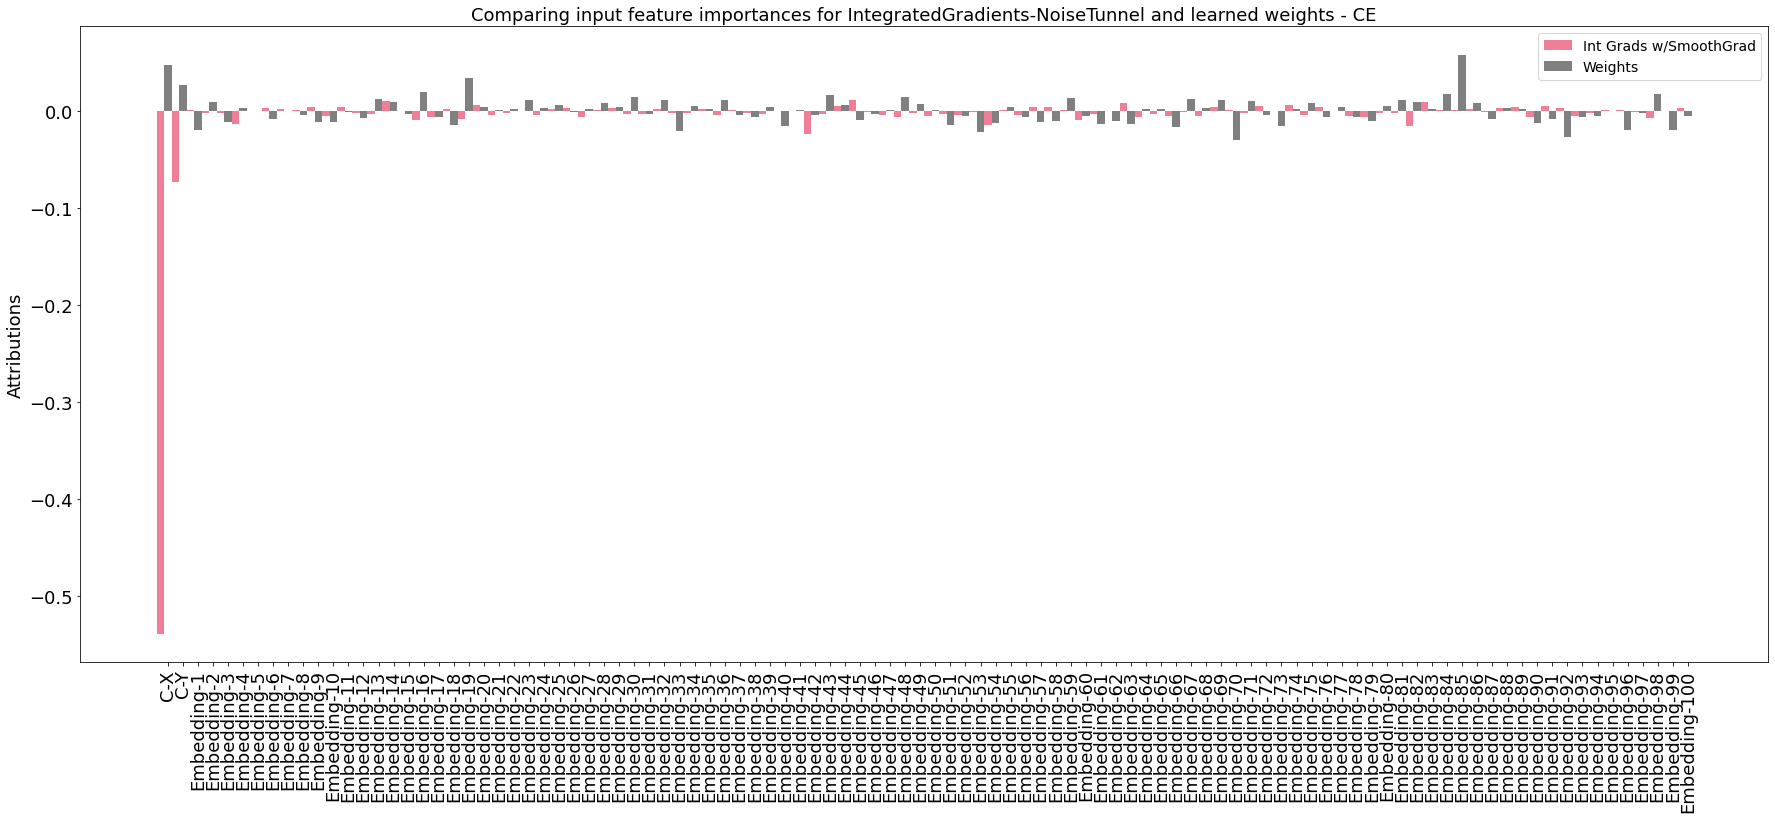

CPU times: user 7min 11s, sys: 1.16 s, total: 7min 13s
Wall time: 7min 10s


In [48]:
%%time
# Attribution check for CrossEntropy head

ig_nt = NoiseTunnel(ig)
# Target is not needed if the number of output neuron is 1.
ig_nt_attr_test = ig_nt.attribute(inputs=X_test, target=X_test_target.squeeze(1).type(torch.IntTensor).tolist())
print('ig_nt_attr_test -> ', ig_nt_attr_test.size())
visualize_attribution(X_test, ig_nt_attr_test, 'Int Grads w/SmoothGrad', 'Comparing input feature importances for IntegratedGradients-NoiseTunnel and learned weights - CE')

gs_attr_test ->  torch.Size([1320, 102])


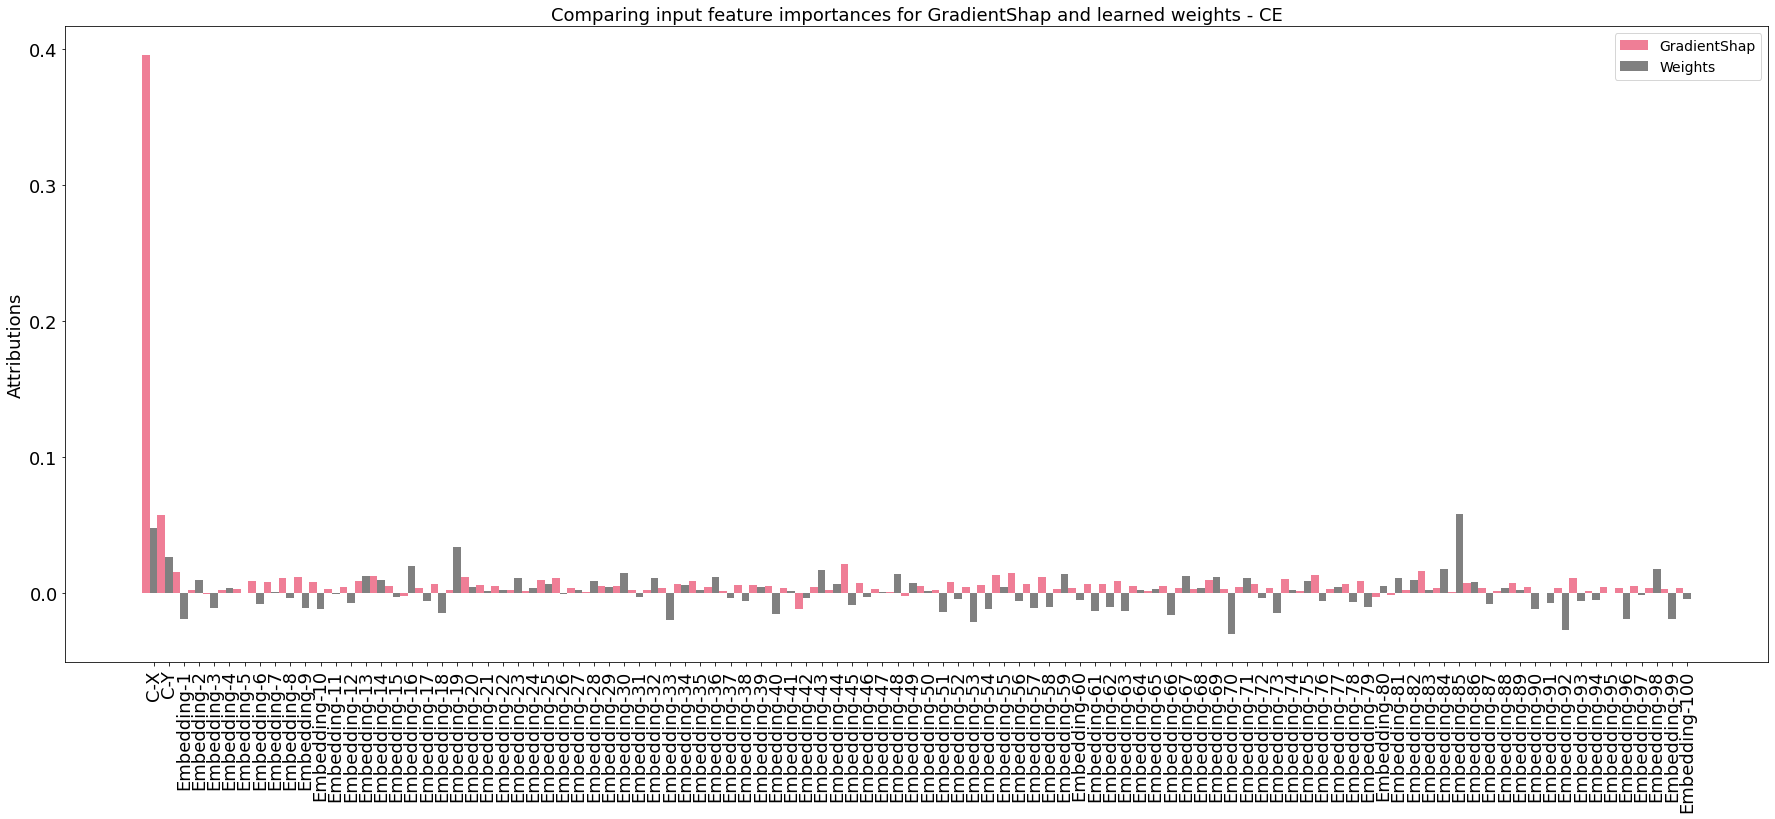

CPU times: user 2 s, sys: 172 ms, total: 2.17 s
Wall time: 1.82 s


In [49]:
%%time
# Attribution check for CrossEntropy head

gs = GradientShap(modified_f)
# Target is not needed if the number of output neuron is 1.
gs_attr_test = gs.attribute(inputs=X_test, baselines=X_train, target=X_test_target.squeeze(1).type(torch.IntTensor).tolist())
print('gs_attr_test -> ', gs_attr_test.size())
visualize_attribution(X_test, gs_attr_test, 'GradientShap', 'Comparing input feature importances for GradientShap and learned weights - CE')

fa_attr_test ->  torch.Size([1320, 102])


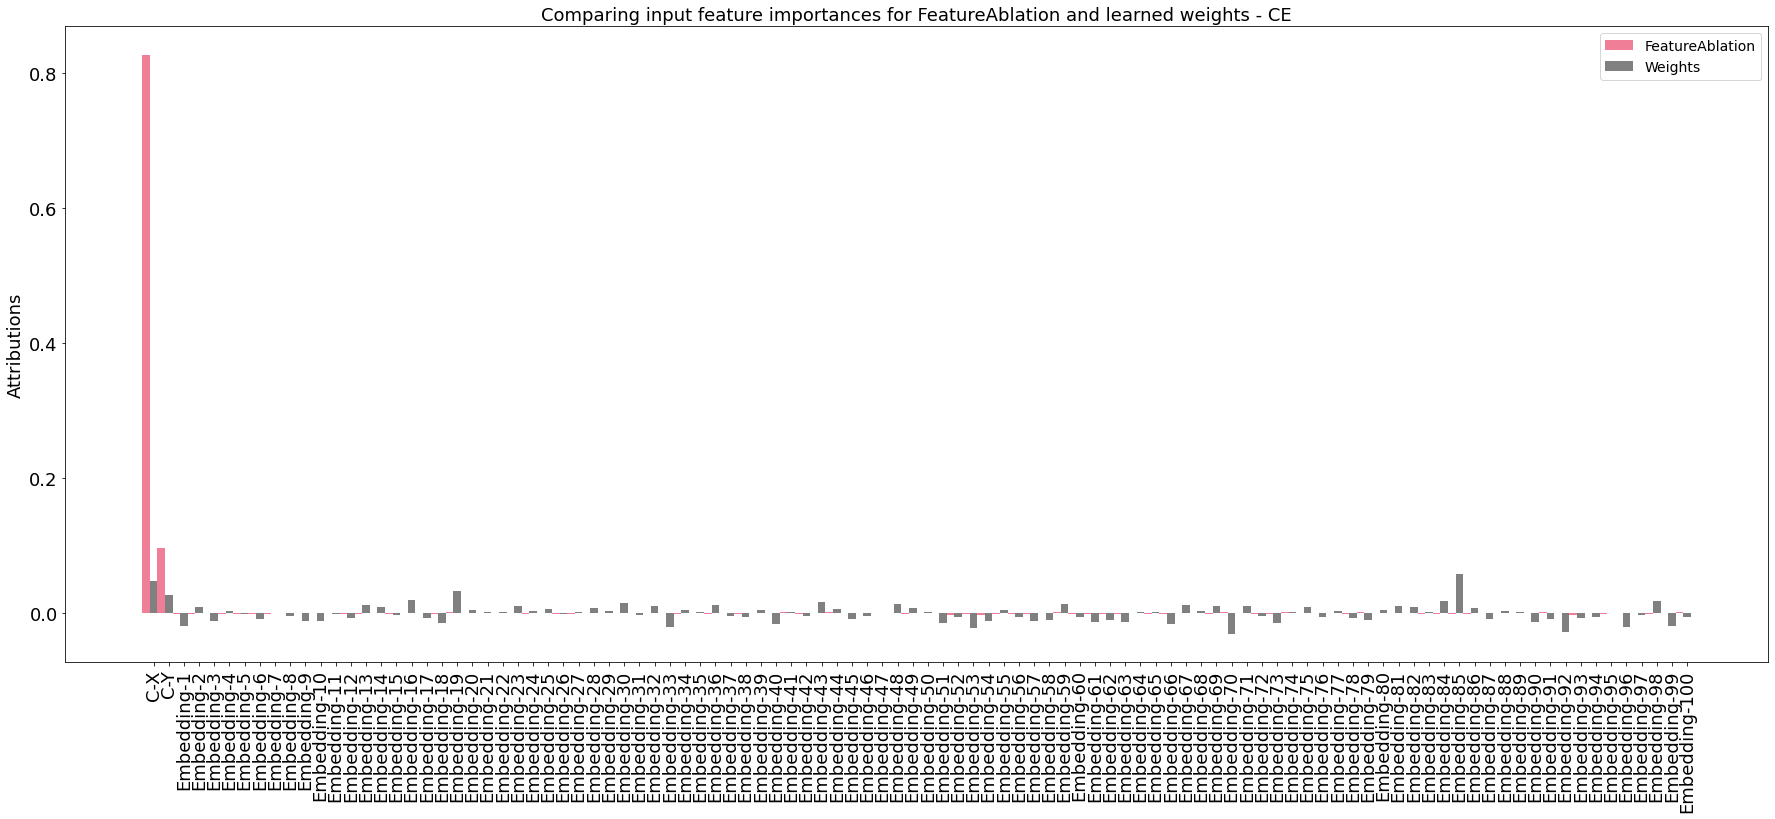

CPU times: user 2.21 s, sys: 136 ms, total: 2.35 s
Wall time: 1.67 s


In [50]:
%%time
# Attribution check for CrossEntropy head

fa = FeatureAblation(modified_f)
# Target is not needed if the number of output neuron is 1.
fa_attr_test = fa.attribute(inputs=X_test, target=X_test_target.squeeze(1).type(torch.IntTensor).tolist())
print('fa_attr_test -> ', fa_attr_test.size())
visualize_attribution(X_test, fa_attr_test, 'FeatureAblation', 'Comparing input feature importances for FeatureAblation and learned weights - CE')

# Part 2

In [53]:
model_key = LitKeyModel.load_from_checkpoint(checkpoint_path='../logs'+ '/' + '2022-01-06_combined_orc_kyc-key-fields' +'/version_0/checkpoints/epoch=149-step=8699.ckpt', train_loader=train_key_loader, val_loader=val_key_loader)
model_key.eval()

LitKeyModel(
  (criterion): CrossEntropyLoss()
  (model): KeyModel(
    (fc1): Linear(in_features=102, out_features=256, bias=True)
    (fc): Linear(in_features=256, out_features=15, bias=True)
    (relu): ReLU()
  )
)

In [8]:
pd.set_option('display.max_rows', 10)
df = pd.read_csv(ANNOTATION_FILE)
df.head()

agama_annotated status_perkawinan_annotated pekerjaan_annotated  \
0        KATHOLIK                       KAWIN     KARYAWAN SWASTA   
1        KATHOLIK                       KAWIN     KARYAWAN SWASTA   
2             NaN                       KAWIN                 WNI   
3           ISLAM                       KAWIN     KARYAWAN SWASTA   
4         KRISTEN                 BELUM KAWIN         BELUM TIDAK   

  kewarganegaraan_annotated berlaku_hingga_annotated   id  image_id  \
0                       WNI               07-09-2017  570       NaN   
1                       WNI               07-09-2017  569       NaN   
2              SEUBUR HIDUP                      NaN  568       NaN   
3                       WNI             SEUMUR HIDUP  567       NaN   
4                       NaN                      NaN  566       NaN   

   internal_image_id  url                                              image  \
0                NaN  NaN  https://storage.googleapis.com/som-mlserver/oc...   
1                NaN  NaN  https://storage.googleapis.com/som-mlserver/oc...   
2                NaN  NaN  https://storage.googleapis.com/som-mlserver/oc...   
3                NaN  NaN  https://storage.googleapis.com/som-mlserver/oc...   
4                NaN  NaN  https://storage.googleapis.com/som-mlserver/oc...   

   ...        berlaku_hingga nik_annotated       nama_annotated  \
0  ...            07-09-2017  3.515185e+15  ANNA MARIA ANDRIANI   
1  ...            07-09-2017  3.515185e+15  ANNA MARIA ANDRIANI   
2  ...  KAIAN SEJAHTERA MOAM  6.471051e+15              PUUANTO   
3  ...                 ALDEA  6.471051e+15              PUJANTO   
4  ...              Bol De 0  3.578263e+15      JEFFRY BOETRENO   

  tgl_lahir_annotated jenis_kelamin_annotated tempat_annotated  \
0          07-09-1972               PEREMPUAN           MALANG   
1          07-09-1972               PEREMPUAN           MALANG   
2          07-04-1981               LAKI-LAKI       SOJONEGORO   
3          07-08-1981               LAKI-LAKI       BOJONEGORO   
4          27-01-1977               LAKI-LAKI         GURADAYA   

                                    alamat_annotated rt_rw_annotated  \
0                                JL. MANGGA VI/E-400         021/006   
1                                JL. MANGGA VI/E-400       021 / 006   
2     PERUM KAIN SETERA BADAM REGENCY BLOCK C2 NO 03         010/004   
3  PERUM KRIAN SEJANTERA INDAH REGENCY BLOK C2 NO BJ         019/004   
4                      KALIJUDAN MADOYA 1/1 SURABAYA         004/004   

  kel_desa_annotated kecamatan_annotated  
0       TAMBAK SUMUR                WARU  
1       TAMBAK SUMUR                WARU  
2            GAMPING                 NaN  
3            GAMPING               KRIAN  
4          KALIMUDAN           MULYDREJO  

[5 rows x 33 columns]

In [141]:
data_key_value_train = clean_data(TRAIN_DATA_KTP_KEY_FIELD_DIR)
data_key_value_val = clean_data(VAL_DATA_KTP_KEY_FIELD_DIR)
data_key_value_test = clean_data(TEST_DATA_KTP_KEY_FIELD_DIR)

284it [00:00, 514.25it/s] 
39it [00:00, 913.30it/s]
75it [00:00, 975.20it/s]


In [142]:
data_key_value_train[0]

{'file_name': '202106100907_0a',
 'file_path': '../data/interim/2022-01-06_combined_orc_kyc-key-fields/KTP_TRAIN/202106100907_0a.jpg',
 'image_width': 664,
 'image_height': 418,
 'normalized_image_width': 564,
 'normalized_image_height': 330,
 'data': [{'locale': 'id',
   'description': "PRI VS al\nKABUPARTIS\n2000', 0126900n3\nNa\nSYAF RIZAL\nTopit UDANG RIMBO,\nTLAKI LAKI\nOstalo\nArt\nIL TRO ALDAR\n1002 10\nALLEMANDAN\nMANDAU\nM\n31AM\nA.\npels\nVAKAVASTE\nKonstant\nBersatu Hongsaid.11.2017\nREMOVALIS\non1 1012\n",
   'boundingPoly': {'vertices': [{'x': 35, 'y': 19},
     {'x': 599, 'y': 19},
     {'x': 599, 'y': 349},
     {'x': 35, 'y': 349}],
    'normalized_vertices': [{'x': 0, 'y': 0},
     {'x': 564, 'y': 0},
     {'x': 564, 'y': 330},
     {'x': 0, 'y': 330}]},
   'cx': 317,
   'cy': 184,
   'n_cx': 282,
   'n_cy': 165,
   'class_index': '0',
   'class': 'TEXT',
   'is_key': False},
  {'description': 'PRI',
   'boundingPoly': {'vertices': [{'x': 261, 'y': 19},
     {'x': 303,

In [146]:
def resize_point(image_width, image_height, point, size=RESIZE):
    new_w, new_h = size
    ratio_w = new_w / image_width
    ratio_h = new_h / image_height
    return (point[0] * ratio_w, point[1] * ratio_h)

def clean_key_fields(key_fields):
    for key in key_fields.keys():
        if key_fields[key]:
            key_fields[key] = list(np.median(key_fields[key], axis=0))
        else:
            key_fields[key] = []
    return key_fields

def clean_value_fields(value_field, key_fields, max_dist):
    value_field['key_field_associations'] = {key: [np.arctan((value_field['resized_n_cy']-value[1])/(value_field['resized_n_cx']-value[0])),
                                                   np.linalg.norm(np.asarray([value_field['resized_n_cx'], value_field['resized_n_cy']])-np.asarray([value[0], value[1]])) / max_dist,
                                                   np.linalg.norm(np.asarray([value_field['resized_n_cx'], value_field['resized_n_cy']])-np.asarray([value[0], value[1]])),
                                                   np.arctan((value_field['resized_n_cy']-value[1])/(value_field['resized_n_cx']-value[0])) * 180/np.pi, 
                                                   value[0],
                                                   value[1]] if value else None for key, value in key_fields.items()}

def associate_tag(value_field):
    associations = copy.deepcopy(value_field['key_field_associations'])
    associations = dict(sorted(associations.items(), key=lambda x: x[1][5] if x[1] else 0))
    keys = list(associations.keys())
    total_items = len(keys)
    for i, key in enumerate(keys):
        if not associations[key]:
            continue
        if value_field['resized_n_cy'] >= associations[key][5]-10:
            if i == total_items-1:
                value_field['tag'] = key
                return
            else:
                for j in range(i+1, total_items):
                    if associations[keys[j]]:
                        break
#                 if value_field['resized_n_cy'] <= associations[keys[j]][5]+5:
                if value_field['resized_n_cy'] <= associations[key][5]+7:
                    value_field['tag'] = key
                    return
    value_field['tag'] = classes[0]

def pre_process(data, normalized_width, normalized_height, max_dist):
    key_fields = {i: [] for i in classes}
    for ind, item in enumerate(data):
        center_coords = resize_point(normalized_width, normalized_height, (item['n_cx'], item['n_cy']))
        item['resized_n_cx'], item['resized_n_cy'] = center_coords[0], center_coords[1]
        item['resized_n_cx_normalized'], item['resized_n_cy_normalized'] = item['resized_n_cx']/RESIZE[0], item['resized_n_cy']/RESIZE[1]
        item['boundingPoly']['resized_normalized_vertices'] = []
        for normalized_vertex in item['boundingPoly']['normalized_vertices']:
            x, y = resize_point(normalized_width, normalized_height, (normalized_vertex['x'], normalized_vertex['y']))
            item['boundingPoly']['resized_normalized_vertices'].append({'x': int(x), 'y': int(y)})
        item['resized_bb_width'] = max(item['boundingPoly']['resized_normalized_vertices'][1]['x'], item['boundingPoly']['resized_normalized_vertices'][2]['x']) - min(item['boundingPoly']['resized_normalized_vertices'][0]['x'], item['boundingPoly']['resized_normalized_vertices'][3]['x'])
        item['resized_bb_height'] = max(item['boundingPoly']['resized_normalized_vertices'][2]['y'], item['boundingPoly']['resized_normalized_vertices'][3]['y']) - min(item['boundingPoly']['resized_normalized_vertices'][0]['y'], item['boundingPoly']['resized_normalized_vertices'][1]['y'])               
        if ind == 0:
            continue
        if item['is_key']:
            key_fields[item['class']].append([item['resized_n_cx'], item['resized_n_cy']])
    key_fields = clean_key_fields(key_fields)
    for ind, item in enumerate(data):
        if ind == 0 or item['is_key']:
            continue
        clean_value_fields(item, key_fields, max_dist)
        associate_tag(item)

def is_aplha(s):
    return int(s.isalpha())

def is_numeric(s):
    return int(s.isnumeric())

def is_alnum(s):
    return int(s.isalnum())

def is_decimal_number(s):
    return int(bool(re.match("[\d.\d]+$", s)))

def is_number_with_symbols(s):
    return int(bool(re.match("[\d{}]+$".format(re.escape(string.punctuation)), s)))

def is_date(s, fuzzy=False):
    try: 
        parse(s, fuzzy=fuzzy)
        return 1
    except (ValueError, OverflowError):
        return 0

def is_zipcode(s):
    return int(len(s) == 5 and s.isnumeric())

def is_gender(s):
    # Refer https://media.neliti.com/media/publications/180589-EN-gender-and-the-indonesian-pronouns.pdf
    return int(s.lower() in ['laki-laki', 'laki', 'perempuan', 'pria', 'wanita', 'jejaka', 'gadis', 'cowok', 'céwék', 'cewek', 'raja', 'ratu', 'pangéran', 'pangeran'])

def is_religion(s):
    return int(s.lower() in ['hindu', 'budha', 'katolik', 'islam', 'kristen', 'protestantisme', 'konfusianisme'])

def get_embeddings(word:str):
    misc_word_embeddings = [
        is_aplha(word),
        is_numeric(word),
        is_alnum(word),
        is_decimal_number(word),
        is_number_with_symbols(word),
        is_date(word),
        is_zipcode(word),
        is_gender(word),
        is_religion(word)
    ]
    return misc_word_embeddings

In [147]:
def prepare_value_df(data):
    data_list = []
    max_dist = math.sqrt(abs(RESIZE[0]**2 + RESIZE[1]**2))
    for doc in tqdm(data):        
        pre_process(doc['data'], doc['normalized_image_width'], doc['normalized_image_height'], max_dist)
        for ind, doc_item in enumerate(doc['data']):
            if ind == 0 or doc_item['is_key']:
                continue
            base_data = [
                doc['file_name'],
                doc['file_path'],
                doc_item['description'],
            ]
            angle_data, dist_data = [], []
            for _, i in doc_item['key_field_associations'].items():
                if i:
                    angle_data.append(i[0])
                    dist_data.append(i[1])
                else:
                    angle_data.append(None)
                    dist_data.append(None)
            derived_data = [
                doc_item['resized_n_cx'],
                doc_item['resized_n_cy'],
                doc_item['resized_bb_width'],
                doc_item['resized_bb_height'],
                doc_item['resized_n_cx_normalized'],
                doc_item['resized_n_cy_normalized'],
                doc['normalized_image_width'],
                doc['normalized_image_height']
            ] + angle_data + dist_data + get_embeddings(doc_item['description'])
            labels = [
                doc_item['tag']
            ]
            data_list.append(
                base_data + derived_data + labels
            )
#             print(len(base_data + derived_data + labels))
    return pd.DataFrame(data_list, columns=
                        ['file_name', 'file_path', 'text']
                      + ['c_x', 'c_y', 'bb_width', 'bb_height', 'n_c_x', 'n_c_y', 'n_image_width', 'n_image_height']
                      + ['EA_'+i.lower() for i in classes]
                      + ['ED_'+i.lower() for i in classes]
                      + ['is_alpha', 'is_numeric', 'is_alnum', 'is_decimal_number', 'is_number_with_symbols', 'is_date', 'is_zipcode', 'is_gender', 'is_religion']
                      + ['label']
                    )
        
train_key_value_df = prepare_value_df(data_key_value_train)
val_key_value_df = prepare_value_df(data_key_value_val)
test_key_value_df = prepare_value_df(data_key_value_test)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.64it/s]


Text(0.5, 1.0, 'Image - Tags')

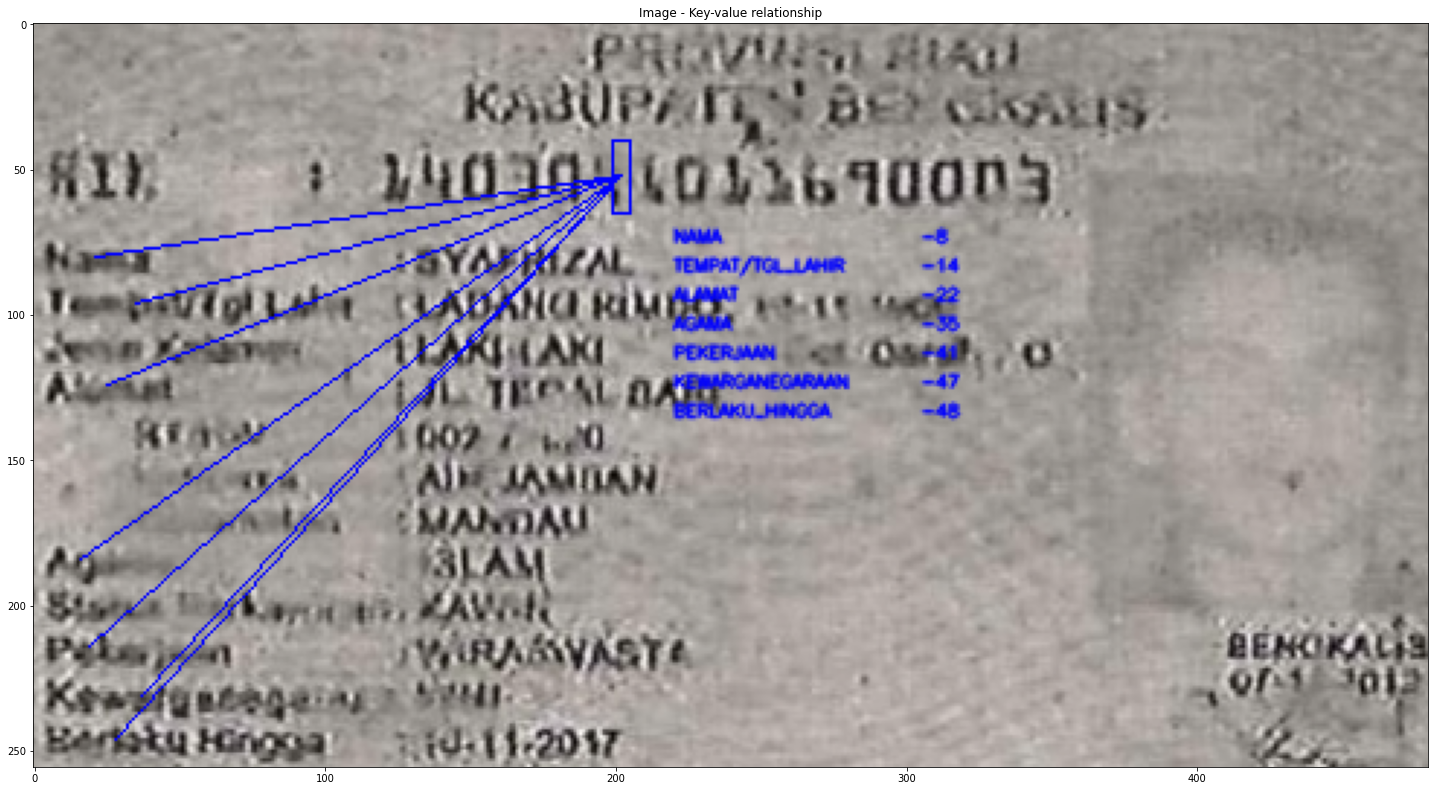

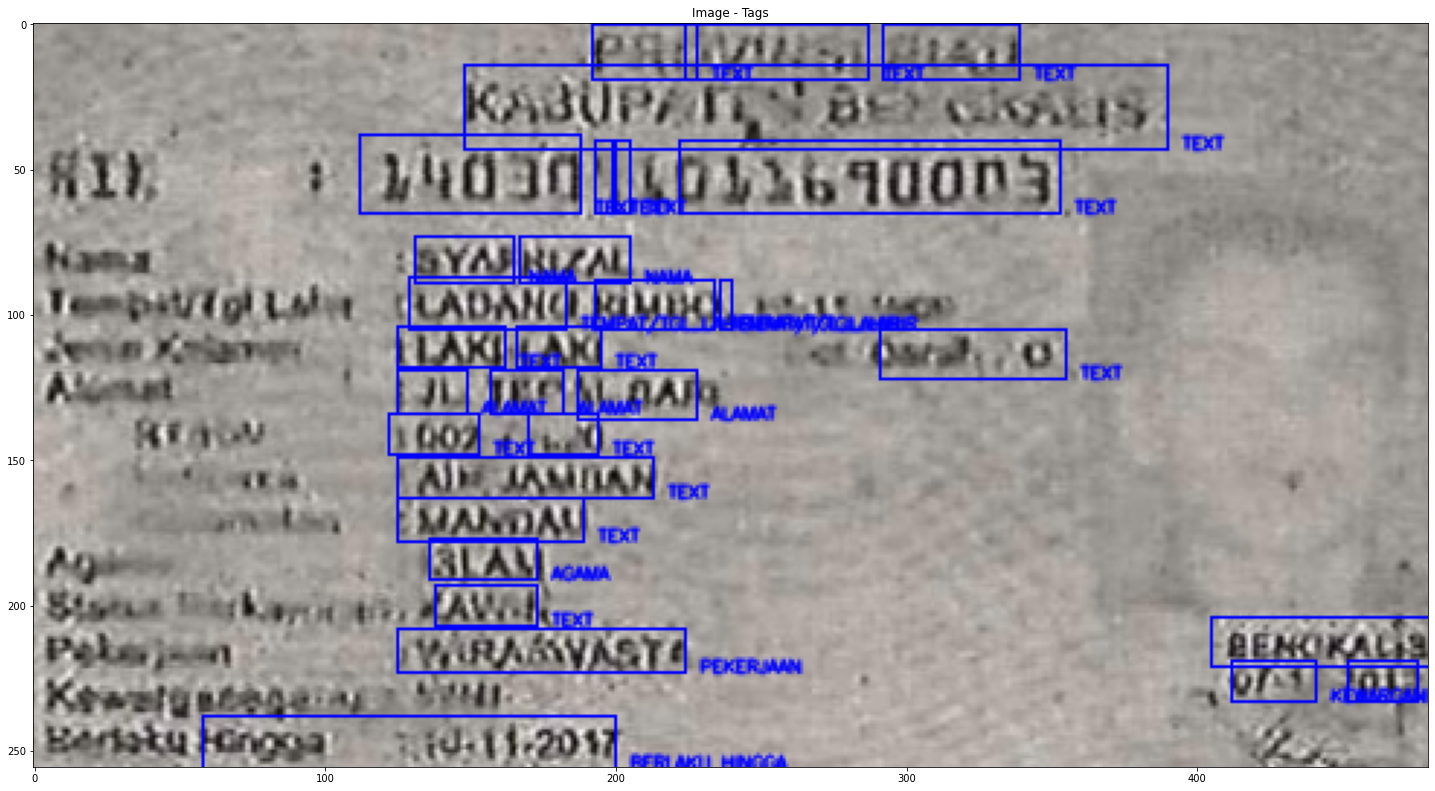

In [148]:
ind = random.randint(0, len(data_key_value_train)-1)
ind = 0
image = cv2.imread(data_key_value_train[ind]['file_path'])
image = image[
    data_key_value_train[ind]['data'][0]['boundingPoly']['vertices'][0]['y']
    :
    data_key_value_train[ind]['data'][0]['boundingPoly']['vertices'][2]['y'],
    data_key_value_train[ind]['data'][0]['boundingPoly']['vertices'][0]['x']
    :
    data_key_value_train[ind]['data'][0]['boundingPoly']['vertices'][2]['x'],
    :
]
plot_for_detection = 7
r = lambda: random.randint(0,255)
image = cv2.resize(image, RESIZE)
image_tag = copy.deepcopy(image)
for i, key in enumerate(data_key_value_train[ind]['data']):
    try:   
        if i == plot_for_detection and not key['is_key']:
            color = (0, 0, 255)
            image = cv2.rectangle(image, (key['boundingPoly']['resized_normalized_vertices'][0]['x'], key['boundingPoly']['resized_normalized_vertices'][0]['y']), (key['boundingPoly']['resized_normalized_vertices'][2]['x'], key['boundingPoly']['resized_normalized_vertices'][2]['y']), color, 1)
            ctr = 0
            for association in key['key_field_associations'].items():
                association_keys, association_values = association
                if association_values:
                    image = cv2.line(image, (int(key['resized_n_cx']), int(key['resized_n_cy'])), (int(association_values[4]), int(association_values[5])), color, 1)
                    image = cv2.putText(image, str(int(association_values[3])) , (key['boundingPoly']['resized_normalized_vertices'][2]['x'] + 100, key['boundingPoly']['resized_normalized_vertices'][2]['y'] + (ctr+1)*10), cv2.FONT_HERSHEY_SIMPLEX, 0.20, color, 1, cv2.LINE_AA)
                    image = cv2.putText(image, association_keys, (key['boundingPoly']['resized_normalized_vertices'][2]['x'] + 15, key['boundingPoly']['resized_normalized_vertices'][2]['y'] + (ctr+1)*10), cv2.FONT_HERSHEY_SIMPLEX, 0.20, color, 1, cv2.LINE_AA)
                    ctr += 1
    except Exception as e:
        print(e)
        continue
for i, key in enumerate(data_key_value_train[ind]['data']):
    try:   
        if i != 0 and not key['is_key']:
            color = (0, 0, 255)
            image_tag = cv2.rectangle(image_tag, (key['boundingPoly']['resized_normalized_vertices'][0]['x'], key['boundingPoly']['resized_normalized_vertices'][0]['y']), (key['boundingPoly']['resized_normalized_vertices'][2]['x'], key['boundingPoly']['resized_normalized_vertices'][2]['y']), color, 1)
            image_tag = cv2.putText(image_tag, key['tag'], (key['boundingPoly']['resized_normalized_vertices'][2]['x']+5, key['boundingPoly']['resized_normalized_vertices'][2]['y']), cv2.FONT_HERSHEY_SIMPLEX, 0.20, color, 1, cv2.LINE_AA)
    except Exception as e:
        print(e)
        continue
fig, (ax1) = plt.subplots(1, 1, figsize=(25,25))
ax1.imshow(image)
ax1.set_title("Image - Key-value relationship")
fig, (ax1) = plt.subplots(1, 1, figsize=(25,25))
ax1.imshow(image_tag)
ax1.set_title("Image - Tags")

In [104]:
data_key_value_train[ind]

{'file_name': 'All_KYC_Docs_115a',
 'file_path': '../data/interim/2022-01-06_combined_orc_kyc-key-fields/KTP_TRAIN/All_KYC_Docs_115a.jpg',
 'image_width': 705,
 'image_height': 485,
 'normalized_image_width': 556,
 'normalized_image_height': 337,
 'data': [{'locale': 'id',
   'description': 'PROVINSI SUMATERA UTARA\nKOTA MEDAN.\nKIK :: 1271116_082DOOS\nNama\nYUUNAR\nTempallid Lahir KOTASAN, 26.03.1983\nJenis Kelamin I PEREMPUAN Gol Darah\nNamal\nJL EKA SUKA NOŻEKVIE\nATAW LEN\nKelDesa GEDUNG JOHOR\nKecamatan TEAN JOHOH\nArama\n* ISLAME\nStatus Perkarnan: KAWIN.\nKOTAVEDAN\nPekerjaan MENGURUS RUMAH TANGGA\n150-2012\nKewarganegaraan: VAL\nBartaku Hiroga $26 03 2017\n',
   'boundingPoly': {'vertices': [{'x': 62, 'y': 43},
     {'x': 618, 'y': 43},
     {'x': 618, 'y': 380},
     {'x': 62, 'y': 380}],
    'normalized_vertices': [{'x': 0, 'y': 0},
     {'x': 556, 'y': 0},
     {'x': 556, 'y': 337},
     {'x': 0, 'y': 337}],
    'resized_normalized_vertices': [{'x': 0, 'y': 0},
     {'x': 48

## Detection of value field using rules

In [93]:
temp = train_key_value_df[train_key_value_df['file_name'] == '202106100907_0a']
temp['label'].unique()

array(['TEXT'], dtype=object)

In [28]:
temp['bb_height'].mean()

17.7

## Detection of value field using ML

In [165]:
# Convert to tensor.
class ToTensor:

    def __call__(self, sample):
        embeddings, labels = sample['embeddings'], sample['labels']
        embeddings = torch.from_numpy(embeddings)
        labels = torch.from_numpy(np.asarray(labels))
        return {'embeddings': embeddings.float(), 'labels': labels}
        
        
class CustomDataset(Dataset):
    
    def __init__(self, data, transforms=None, overfit=False, overfit_batch_size=32):
        self.data = data.drop(['file_name', 'text', 'n_image_width', 'n_image_height', 'label'], axis=1)
        self.labels = data[['label']]
        self.overfit = overfit
        self.overfit_batch_size = overfit_batch_size
        self.transforms = transforms

    def __len__(self):
        return len(self.data) if not self.overfit else self.overfit_batch_size

    def __getitem__(self, index):
        sample = {
            'embeddings': np.array(self.data.iloc[index]),
            'labels': self.labels.iloc[index]['label']
        }
        sample_output = self.transforms(sample)
        return sample_output['embeddings'], sample_output['labels']


class Data:

    def __init__(self, train_df, val_df, test_df, transforms=None, batch_size=32, overfit=False, overfit_batch_size=32):
        self.train, self.val, self.test = train_df, val_df, test_df
        self.shuffle = True
        self.batch_size = batch_size
        self.overfit = overfit
        self.overfit_batch_size = overfit_batch_size
        self.transforms = self.get_transforms() if transforms is None or not isinstance(transforms, dict) else transforms

    def get_transforms(self):
        init_factor = 32
        TRANSFORMS = {
            'train': transforms.Compose([
                ToTensor()
            ]),
            'val': transforms.Compose([
                ToTensor()
            ]),
            'test': transforms.Compose([
                ToTensor()
            ])
        }
        return TRANSFORMS

    def get_loaders(self):
        train_dataset = CustomDataset(data=self.train, transforms=self.transforms['train'], overfit=self.overfit, overfit_batch_size=self.overfit_batch_size)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=self.shuffle, pin_memory=True)
        val_dataset = CustomDataset(data=self.val, transforms=self.transforms['val'], overfit=self.overfit, overfit_batch_size=self.overfit_batch_size)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=self.batch_size, shuffle=self.shuffle, pin_memory=True)
        test_dataset = CustomDataset(data=self.test, transforms=self.transforms['test'], overfit=self.overfit, overfit_batch_size=self.overfit_batch_size)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=self.batch_size, shuffle=self.shuffle, pin_memory=True)
        return train_dataset, train_loader, val_dataset, val_loader, test_dataset, test_loader

    def visualize_outputs(self):
        _, trainloader, _, _, _, _ = self.get_loaders()
        dataiter = iter(trainloader)
        embeddings, labels = dataiter.next()
        print('Model input => ', embeddings.size())
        print('Model output => ', labels.size())

In [166]:
data = Data(train_key_value_df, train_key_value_df, train_key_value_df)

In [167]:
data.visualize_outputs()

Model input =>  torch.Size([30, 41])
Model output =>  torch.Size([30])


In [ ]:
_, train_loader, _, val_loader, _, test_loader = data.get_loaders()

In [ ]:
class Model(nn.Module):

    def __init__(self, output_neurons=len(cl)):
        super().__init__()
        self.fc1 = nn.Linear(41, 256)
        self.fc2 = nn.Linear(256, output_neurons)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc2(self.relu(self.fc1(x)))
        return F.log_softmax(x,dim = 1)
    
    
model = Model()
output = model(torch.randn(32, 125))
print(type(output))
print(output.shape)

In [ ]:
class LitModel(pl.LightningModule):

    def __init__(self, train_loader, val_loader, batch_size=128, learning_rate=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01):
        super().__init__()
        self.criterion = torch.nn.CrossEntropyLoss()
        self.model = Model()
        self.learning_rate=learning_rate
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.batch_size = batch_size
        self.betas = betas
        self.eps = eps
        self.weight_decay = weight_decay

    def forward(self, x):
        return self.model(x)

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self.forward(x)    
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self.forward(x)    
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        y_hat = self.forward(x)    
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss, prog_bar=True, on_epoch=True)
        return loss
    
    def train_dataloader(self):
        return self.train_loader

    def val_dataloader(self):
        return self.val_loader

    def configure_optimizers(self):
        steps_per_epoch = len(self.train_loader) // self.batch_size
        optimizer = torch.optim.AdamW(
            self.parameters(), 
            lr=self.learning_rate, 
            betas=self.betas, 
            eps=self.eps, 
            weight_decay=self.weight_decay)
        cyclic_lr_scheduler = {
            "scheduler": CyclicLR(
                optimizer=optimizer,
                base_lr=self.learning_rate,
                max_lr=1e-6,
                cycle_momentum=False # False with AdamW
            ),
            "interval": "step",
        }
        return [optimizer], [cyclic_lr_scheduler]
    
    def get_progress_bar_dict(self):
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        items.pop("loss", None)
        return items

In [ ]:
model = LitModel(train_loader=train_loader, val_loader=val_loader, batch_size=32)
trainer = pl.Trainer(auto_lr_find=True, gpus=1 if torch.cuda.is_available() else None, progress_bar_refresh_rate=0, default_root_dir='../logs')
lr_finder = trainer.tuner.lr_find(model)
fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
trainer = pl.Trainer(default_root_dir='../logs',
                     precision=32,
                     limit_train_batches=0.5,
                     gpus=1 if torch.cuda.is_available() else None, 
                     max_epochs=10,
                     logger=TensorBoardLogger('../logs', name='temp_1'),
                     callbacks=[
                            LearningRateMonitor(logging_interval="step"), 
                            ModelCheckpoint(monitor="train_loss"),
                        ],
#                      resume_from_checkpoint='../logs' + '/' +'temp_1' +'/version_0/checkpoints/epoch=98-step=6137.ckpt'
                     )

trainer.fit(LitModel(train_loader=train_loader, val_loader=val_loader))

In [ ]:
model = LitModel.load_from_checkpoint(checkpoint_path='../logs'+ '/' + 'temp_1' +'/version_2/checkpoints/epoch=9-step=609.ckpt', train_loader=train_loader, val_loader=val_loader)

In [ ]:
model

In [ ]:
trainer.test(model, dataloaders=test_loader)

In [ ]:
df_dict_res = {
    'ground_truth': [],
    'predicted_values': []
}
for embeddings, labels in test_loader:
    y_hat = model(embeddings)
    y_hat = y_hat.cpu().detach().numpy()
    y_hat = np.argmax(y_hat, axis=1)
    labels = labels.cpu().detach().numpy()
    for i in range(len(labels)):
        df_dict_res['ground_truth'].append(labels[i])
        df_dict_res['predicted_values'].append(y_hat[i])
df_res = pd.DataFrame.from_dict(df_dict_res)
df_res